# ccb model based on bucketing

结果分析：

经过分类分析发现，当factor1选定为'price_diff_20'时，factor2选定为'close'、'conversion_value'、'yield_to_maturity'，结合得到的新因子的分类效果较好。

### data preparation

In [1]:
import pandas_market_calendars as mcal
import pandas as pd
from ic_group import *
from visualize import *
import numpy as np
from scipy.stats import norm
from datetime import datetime,timedelta
import random

In [2]:
df_call_historic_vol_y = pd.read_csv('df_call_historic_vol_y.csv')
df_call_historic_vol_y

Unnamed: 0        date order_book_id     open     high      low  \
0                0  2019-01-02   113011.XSHG  105.000  105.470  103.400   
1                1  2019-01-02   110030.XSHG  102.260  102.350  102.250   
2                2  2019-01-02   113510.XSHG   93.100   93.400   93.010   
3                3  2019-01-02   128042.XSHE   94.600   94.986   94.380   
4                4  2019-01-02   113017.XSHG   92.000   92.150   91.470   
...            ...         ...           ...      ...      ...      ...   
350358      350358  2023-07-04   123046.XSHE  411.738  416.715  406.919   
350359      350359  2023-07-04   128030.XSHE  235.477  238.500  224.737   
350360      350360  2023-07-04   127014.XSHE  228.777  232.311  227.350   
350361      350361  2023-07-04   123104.XSHE  112.300  114.550  111.202   
350362      350362  2023-07-04   123180.XSHE  123.499  124.499  123.314   

          close     volume         money  num_trades  ... conversion_price  \
0       103.780   823250.0  8.566986e+07         0.0  ...             4.13   
1       102.320    18810.0  1.924131e+06         0.0  ...             6.94   
2        93.030     1920.0  1.791770e+05         0.0  ...            11.32   
3        94.748    12151.0  1.149000e+06        97.0  ...            13.25   
4        92.060    38480.0  3.539767e+06         0.0  ...             2.96   
...         ...        ...           ...         ...  ...              ...   
350358  412.990   575280.0  2.370410e+08     17278.0  ...             3.91   
350359  228.977   191480.0  4.373473e+07      3464.0  ...             7.18   
350360  228.698  1595470.0  3.666792e+08     31076.0  ...             7.80   
350361  112.900  1148312.0  1.292685e+08     19396.0  ...            17.71   
350362  124.320   175429.0  2.175423e+07      4464.0  ...            48.49   

       logreturn_y  historic_vol_10  call_historic_vol_10  historic_vol_20  \
0              NaN              NaN                   NaN              NaN   
1              NaN              NaN                   NaN              NaN   
2              NaN              NaN                   NaN              NaN   
3              NaN              NaN                   NaN              NaN   
4              NaN              NaN                   NaN              NaN   
...            ...              ...                   ...              ...   
350358   -0.368986       202.253546            193.861893       150.163784   
350359   -6.997921        28.701125            106.964917        33.576373   
350360   -0.056837       100.035611            204.743590        60.277292   
350361    0.265863        25.984888             43.647591        14.697374   
350362    1.656457         4.274430             79.757312        11.538758   

       call_historic_vol_20  historic_vol_60  call_historic_vol_60  \
0                       NaN              NaN                   NaN   
1                       NaN              NaN                   NaN   
2                       NaN              NaN                   NaN   
3                       NaN              NaN                   NaN   
4                       NaN              NaN                   NaN   
...                     ...              ...                   ...   
350358           193.861893       121.845521            193.861893   
350359           109.107625        31.021104            108.081857   
350360           204.743589        67.333294            204.743590   
350361            43.631996         8.200944             43.242911   
350362            81.001717         8.892997             80.971963   

       historic_vol_250 call_historic_vol_250  
0                   NaN                   NaN  
1                   NaN                   NaN  
2                   NaN                   NaN  
3                   NaN                   NaN  
4                   NaN                   NaN  
...                 ...                   ...  
350358        74.424644            193.861893  
350359  

In [3]:
# calculate price difference
for x in [10,20,60,250]:
    df_call_historic_vol_y[f'price_diff_{x}'] = df_call_historic_vol_y['close'] - df_call_historic_vol_y[f'call_historic_vol_{x}'] - df_call_historic_vol_y['pure_bond_value_1']

In [21]:
df = df_call_historic_vol_y
df = df.sort_values(['order_book_id','date'])
data = df
# 构建因子 
factor1 = 'price_diff_20'
# 预测收益
df['r_1'] = np.where(df.order_book_id==df.order_book_id.shift(-2),df['open'].shift(-2)/df['open'].shift(-1)-1,0)#下一个交易日的收盘价相对于下一日开盘价的收益率
df['r_2'] = np.where(df.order_book_id==df.order_book_id.shift(0),df['close'].shift(0)/df['open'].shift(0)-1,0)#当日收盘价相对于当日开盘价的收益率（ret）
df['convertible_bond_momentum'] = np.where(df.order_book_id == df.order_book_id.shift(5),df.close.shift(0)/df.close.shift(5)-1,0)
df['stock_momentum'] = np.where(df.order_book_id == df.order_book_id.shift(5),df.stock_close.shift(0)/df.stock_close.shift(5)-1,0)
data = df[['date','order_book_id','close','conversion_value','conversion_premium','put_trigger_price','yield_to_maturity','pb_ratio','convertible_bond_momentum','stock_momentum','turnover_rate','r_1','r_2',factor1]].dropna()
data = data[~np.isinf(data['r_1'])]
# the following analyse functions use str type, so change datetime to str
data = data[data['date']>'2021-05-01']
data['date'] = data['date'].apply(lambda x:str(x)[:10])

In [22]:
data

date order_book_id    close  conversion_value  \
130992  2021-05-06   110031.XSHG  106.720         53.710575   
131352  2021-05-07   110031.XSHG  106.680         53.942486   
131712  2021-05-10   110031.XSHG  106.880         59.322820   
132072  2021-05-11   110031.XSHG  107.000         61.595547   
132431  2021-05-12   110031.XSHG  106.790         60.667904   
...            ...           ...      ...               ...   
305417  2023-02-16   128145.XSHE  128.600        128.475551   
305569  2023-02-17   128145.XSHE  132.050        133.173538   
306166  2023-02-20   128145.XSHE  131.670        132.598274   
306644  2023-02-21   128145.XSHE  130.449        130.872483   
306987  2023-02-22   128145.XSHE  127.030        127.708533   

        conversion_premium  put_trigger_price  yield_to_maturity  pb_ratio  \
130992            0.986946             15.092          -0.103529  1.858019   
131352            0.977662             15.092          -0.102643  1.858019   
131712            0.801668             15.092          -0.132462  1.858019   
132072            0.737139             15.092          -0.149241  1.858019   
132431            0.760239             15.092          -0.131204  1.858019   
...                    ...                ...                ...       ...   
305417            0.000969              7.301          -5.705710  3.363541   
305569           -0.008437              7.301          -6.717624  3.486537   
306166           -0.007001              7.301          -8.652776  3.486537   
306644           -0.003236              7.301          -9.324585  3.471476   
306987           -0.005313              7.301          -9.544507  3.426294   

        convertible_bond_momentum  stock_momentum  turnover_rate       r_1  \
130992                   0.001878       -0.041387       0.005315 -0.000187   
131352                   0.000469       -0.030026       0.002522  0.001312   
131712                   0.002157        0.058774       0.030610  0.002902   
132072                   0.002906        0.077047       0.021023 -0.004013   
132431                   0.001125        0.103797       0.010570 -0.000187   
...                           ...             ...            ...       ...   
305417                  -0.048113       -0.055673       1.340473  0.023838   
305569                  -0.014560       -0.011388       4.710959 -0.001518   
306166                  -0.028266       -0.023305       1.621542 -0.009113   
306644                  -0.032356       -0.029851       0.594014  0.000000   
306987                  -0.089391       -0.090164       0.538025  0.000000   

             r_2  price_diff_20  
130992  0.001126      -0.014049  
131352 -0.000375      -0.068770  
131712  0.001687       0.108017  
132072  0.001498       0.220648  
132431 -0.003360       0.000303  
...          ...            ...  
305417 -0.070097     -89.576179  
305569  0.026030     -90.860695  
306166 -0.000744     -90.747133  
306644 -0.008505     -90.230380  
306987 -0.025612     -90.482762  

[200127 rows x 14 columns]

### bucketing

In [15]:
#%%
#计算加权的组内排名
def weighted_group_rank(group_total,volume,ret,cross_sectional_vect,delay=1):
    Instrumentsize=len(ret)#样本总数
    # volume=df[df.date=='2019-01-10']['volume'].reset_index(drop=True)交易量
    # ret=df[df.date=='2019-01-10']['r_2'].reset_index(drop=True)收益率
    # cross_sectional_vect=df[df.date=='2019-01-10']['today'].reset_index(drop=True)横截面因子
    # group_total=5
    
    #计算交易量数据的排名
    criterion = np.full(Instrumentsize, np.nan)
    criterion[:] = volume[:]#factor1
    criterion[:] = pd.Series(criterion[:]).rank()#对factor1排序
    
    grouped_data = np.full((group_total,Instrumentsize),np.nan)#存储横截面因子的数据
    weight_standards = np.full((group_total,Instrumentsize),np.nan)#存储收益率
    group_id = np.full(Instrumentsize, np.nan)#存储每个样本所属的分组编号
    
    """
    根据volume分成5组
    """
    group_id[:] = criterion[:]
    for ii in range(Instrumentsize):
      if not np.isnan(group_id[ii]):
        group_id[ii] = int(np.ceil(group_id[ii]/(Instrumentsize/group_total))-1)#新的组别（0~4），由factor1大小决定
    # group_id[group_id==group_total] = group_total-1
    """
    将因子和收益分别放入对应组
    """
    for ii in range(Instrumentsize):
      if not np.isnan(group_id[ii]):
        grouped_data[int(group_id[ii])][ii] = cross_sectional_vect[ii]#factor2
        weight_standards[int(group_id[ii])][ii] = ret[ii]#收益率
    
    """
    根据收益算各组权重
    """
    group_weight = np.full(group_total, np.nan)
    for ii in range(group_total):
      grouped_data[ii,:] = pd.Series(grouped_data[ii,:]).rank()#factor2排序
      group_weight[ii] = np.nanmean(weight_standards[ii,:])#每组收益率非缺失值的平均值
    group_weight[:] = pd.Series(group_weight[:]).rank()#由ret排序得到权重
    
    """
    根据权重 重构因子
    """
    weighted_group_rank_alpha = np.full(Instrumentsize, np.nan)#存储计算得到的加权组内排名因子
    for ii in range(Instrumentsize):
      if not np.isnan(group_id[ii]):
        weighted_group_rank_alpha[ii] = grouped_data[int(group_id[ii])][ii]*group_weight[int(group_id[ii])]
          
    return weighted_group_rank_alpha

#%%

In [16]:
#%%
"""
新因子是df_rank.factor
"""
#根据给定的两个因子factor1和factor2，以及包含完整数据的DataFrame df_all，计算新的因子并返回一个包含新因子值的DataFrame df_rank
def new_factor(factor1,factor2,df_all):
    df_rank=pd.DataFrame(columns=['date','order_book_id','factor','r_2'])
    date=list(set(df_all.date))
    date.sort()

    for i in range(1,len(date)):
        temp1=df_all[df_all.date==date[i-1]][['order_book_id',factor1,'r_2']].reset_index(drop=True)
        temp2=df_all[df_all.date==date[i]][['date','order_book_id',factor2]].reset_index(drop=True)
        #temp3=df_all[df_all.date==date[i]][['r_1','order_book_id']].reset_index(drop=True)
        temp=pd.merge(temp2,temp1,on=['order_book_id'],how='left').dropna().reset_index(drop=True)
        #temp=pd.merge(temp,temp3,on=['order_book_id'],how='left').dropna().reset_index(drop=True)
    
        volume=temp[factor1].reset_index(drop=True)
        ret=temp['r_2'].reset_index(drop=True)
        cross_sectional_vect=temp[factor2].reset_index(drop=True)
        rank_alpha=weighted_group_rank(5,volume,ret,cross_sectional_vect,delay=1)#计算加权组内排名因子
        new=pd.DataFrame({'date':temp.date,'order_book_id':temp.order_book_id,'factor':rank_alpha,'r_2':temp.r_2})
        df_rank=pd.concat([df_rank,new])
    return df_rank


### factor2 is 'close'

In [24]:
factor2='close'
df_rank=new_factor(factor1,factor2,data)
df_rank=pd.merge(df_rank,df[['date','order_book_id','close',factor1,'conversion_value','conversion_premium','put_trigger_price','yield_to_maturity','pb_ratio','r_1']],on=['date','order_book_id'],how='left')
df_rank

date order_book_id  factor       r_2    close  price_diff_20  \
0       2021-05-07   110031.XSHG   152.0  0.001126  106.680      -0.068770   
1       2021-05-07   110033.XSHG   164.0  0.002114  109.420      -9.100209   
2       2021-05-07   110034.XSHG   160.0 -0.002929  109.010      -7.960988   
3       2021-05-07   110038.XSHG   140.0  0.000957  104.900      -7.487085   
4       2021-05-07   110041.XSHG    44.0  0.008352  106.450     -52.085737   
...            ...           ...     ...       ...      ...            ...   
199301  2023-07-04   128140.XSHE   162.0 -0.004350  189.792     -78.781033   
199302  2023-07-04   128141.XSHE    72.0  0.004282  123.880     -41.616005   
199303  2023-07-04   128142.XSHE    84.0  0.015199  122.841     -57.145875   
199304  2023-07-04   128143.XSHE   183.0 -0.052785  130.871     -59.144454   
199305  2023-07-04   128144.XSHE    60.0  0.002261  115.089     -43.976858   

        conversion_value  conversion_premium  put_trigger_price  \
0              53.942486            0.977662             15.092   
1              97.493036            0.122337              5.026   
2              91.539301            0.190855             12.824   
3              79.035639            0.327249             11.925   
4              89.962825            0.183267              1.883   
...                  ...                 ...                ...   
199301        166.782274            0.137963             18.165   
199302        104.152933            0.189405             10.619   
199303         79.967249            0.536141             12.824   
199304         98.574822            0.327631              8.841   
199305         84.840183            0.356539              7.665   

        yield_to_maturity  pb_ratio       r_1  
0               -0.102643  1.858019  0.001312  
1               -0.041457  0.565588 -0.001828  
2               -0.034542  1.420582 -0.003383  
3                0.006936  2.007766 -0.002097  
4                0.003578  0.937568  0.001784  
...                   ...       ...       ...  
199301          -0.160553  2.235021  0.000000  
199302          -0.047349  1.083574  0.000000  
199303          -0.044953  5.107115  0.000000  
199304          -0.057224  3.483303  0.000000  
199305          -0.027008  1.203502  0.000000  

[199306 rows x 12 columns]

<Figure size 1500x1200 with 0 Axes>

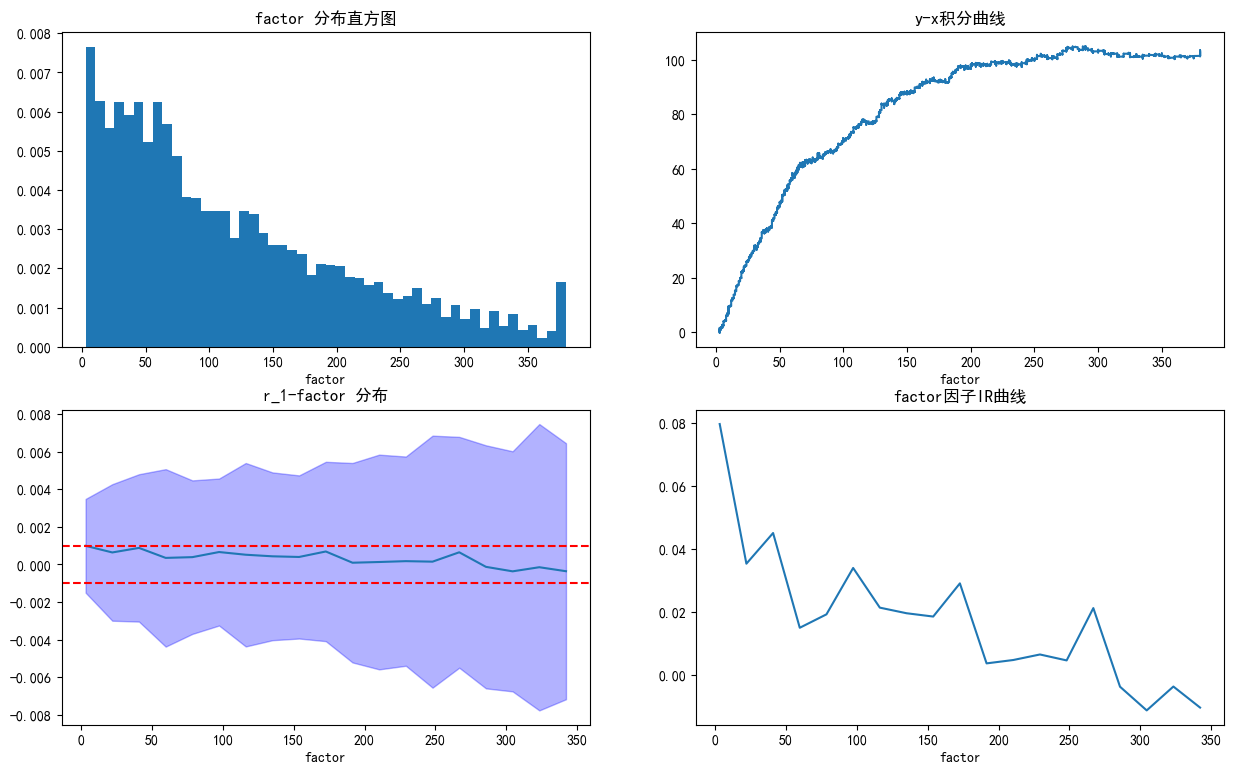

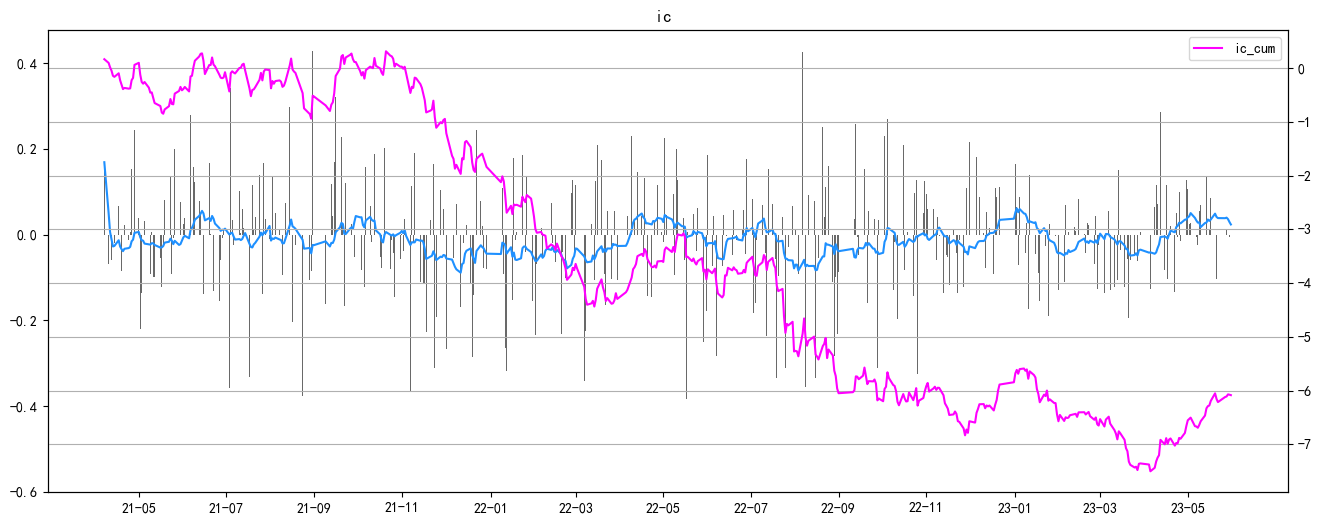

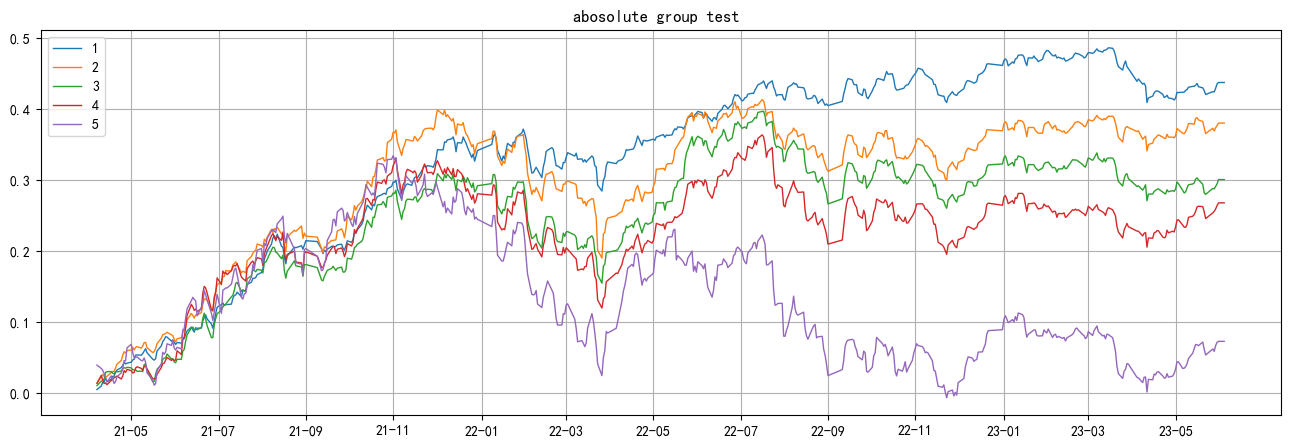

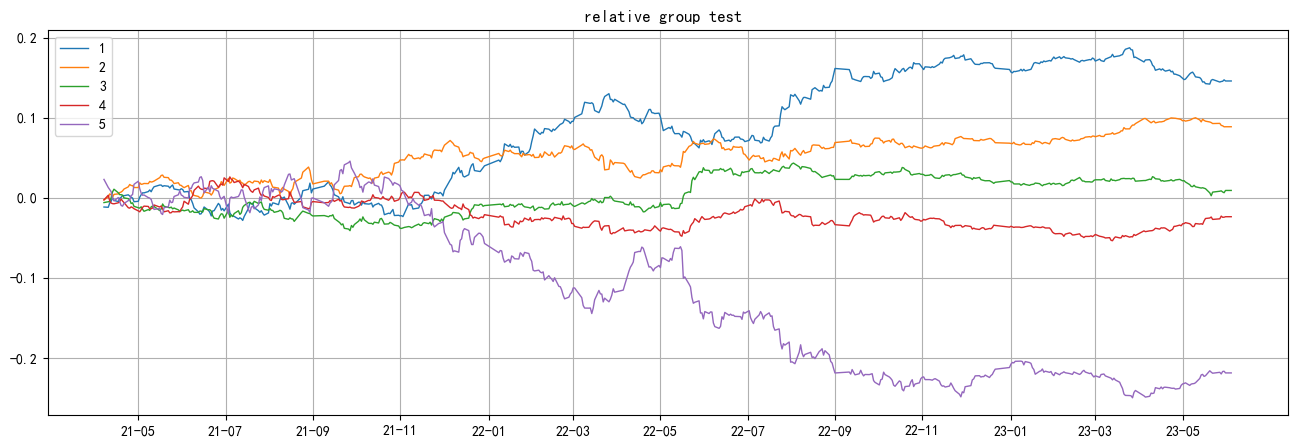

In [25]:
look(df_rank,'factor','r_1',thresh=0.01, div_num=20)
analyse_ic(df_rank,'factor','r_1')    
analyse_group_new(df_rank,'factor','r_1',is_alpha=False,num_group=5)
analyse_group_new(df_rank,'factor','r_1',is_alpha=True,num_group=5)

### factor2 is conversion_value

In [15]:
factor2='conversion_value'
df_rank=new_factor(factor1,factor2,data)
df_rank=pd.merge(df_rank,df[['date','order_book_id',factor1,'close','conversion_value','conversion_premium','put_trigger_price','yield_to_maturity','pb_ratio','r_1']],on=['date','order_book_id'],how='left')
df_rank

date order_book_id  factor       r_2  price_diff_20    close  \
0       2021-05-07   110031.XSHG    44.0  0.001126      -0.068770  106.680   
1       2021-05-07   110033.XSHG   204.0  0.002114      -9.100209  109.420   
2       2021-05-07   110034.XSHG   192.0 -0.002929      -7.960988  109.010   
3       2021-05-07   110038.XSHG   152.0  0.000957      -7.487085  104.900   
4       2021-05-07   110041.XSHG    49.0  0.008352     -52.085737  106.450   
...            ...           ...     ...       ...            ...      ...   
199330  2023-07-04   128140.XSHE   154.0 -0.004350     -78.781033  189.792   
199331  2023-07-04   128141.XSHE    88.0  0.004282     -41.616005  123.880   
199332  2023-07-04   128142.XSHE    12.0  0.015199     -57.145875  122.841   
199333  2023-07-04   128143.XSHE   132.0 -0.052785     -59.144454  130.871   
199334  2023-07-04   128144.XSHE   148.0  0.002261     -43.976858  115.089   

        conversion_value  conversion_premium  put_trigger_price  \
0              53.942486            0.977662             15.092   
1              97.493036            0.122337              5.026   
2              91.539301            0.190855             12.824   
3              79.035639            0.327249             11.925   
4              89.962825            0.183267              1.883   
...                  ...                 ...                ...   
199330        166.782274            0.137963             18.165   
199331        104.152933            0.189405             10.619   
199332         79.967249            0.536141             12.824   
199333         98.574822            0.327631              8.841   
199334         84.840183            0.356539              7.665   

        yield_to_maturity  pb_ratio       r_1  
0               -0.102643  1.858019  0.001123  
1               -0.041457  0.565588  0.005026  
2               -0.034542  1.420582 -0.000367  
3                0.006936  2.007766  0.003152  
4                0.003578  0.937568 -0.000562  
...                   ...       ...       ...  
199330          -0.160553  2.235021  0.000000  
199331          -0.047349  1.083574  0.000000  
199332          -0.044953  5.107115  0.000000  
199333          -0.057224  3.483303  0.000000  
199334          -0.027008  1.203502  0.000000  

[199335 rows x 12 columns]

<Figure size 1500x1200 with 0 Axes>

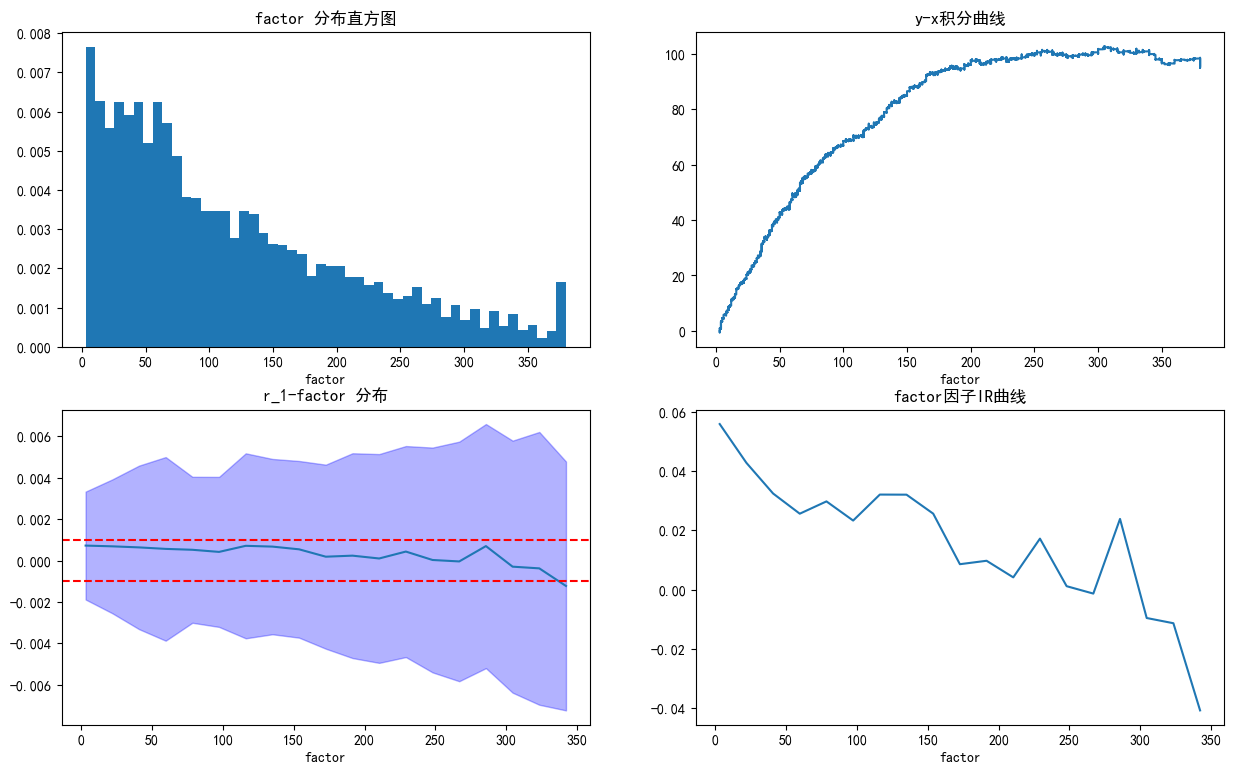

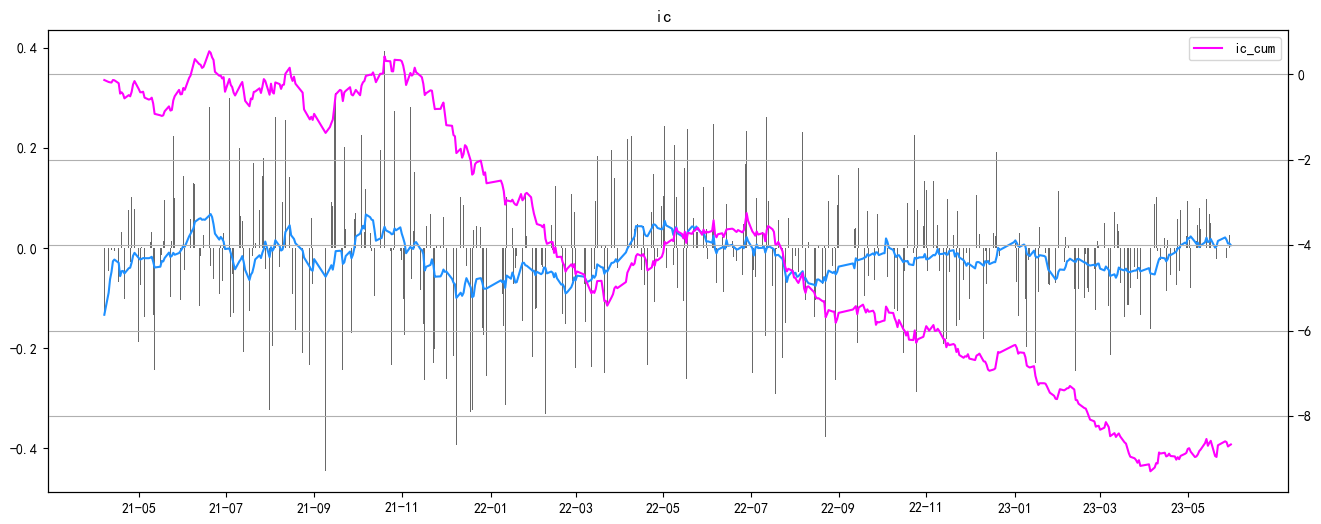

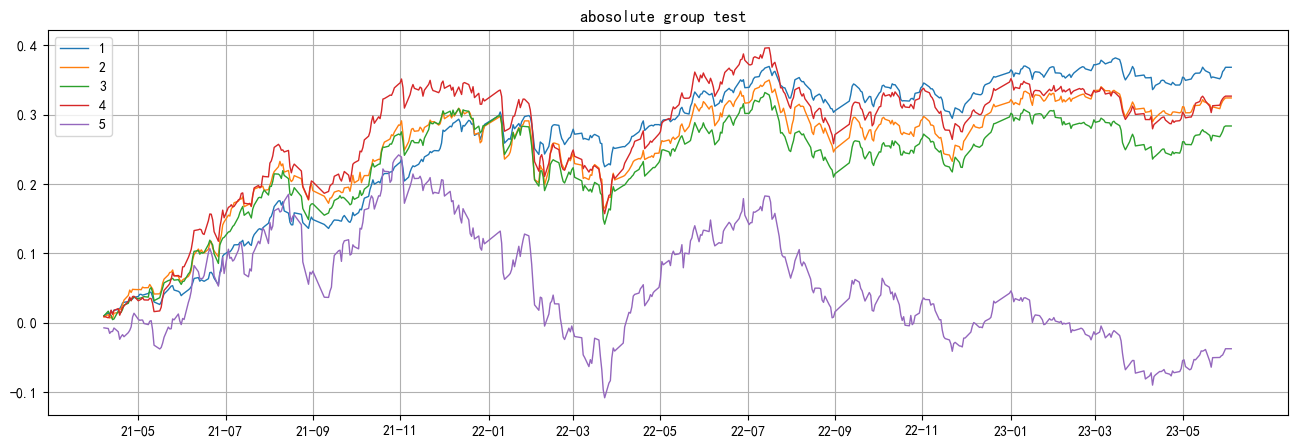

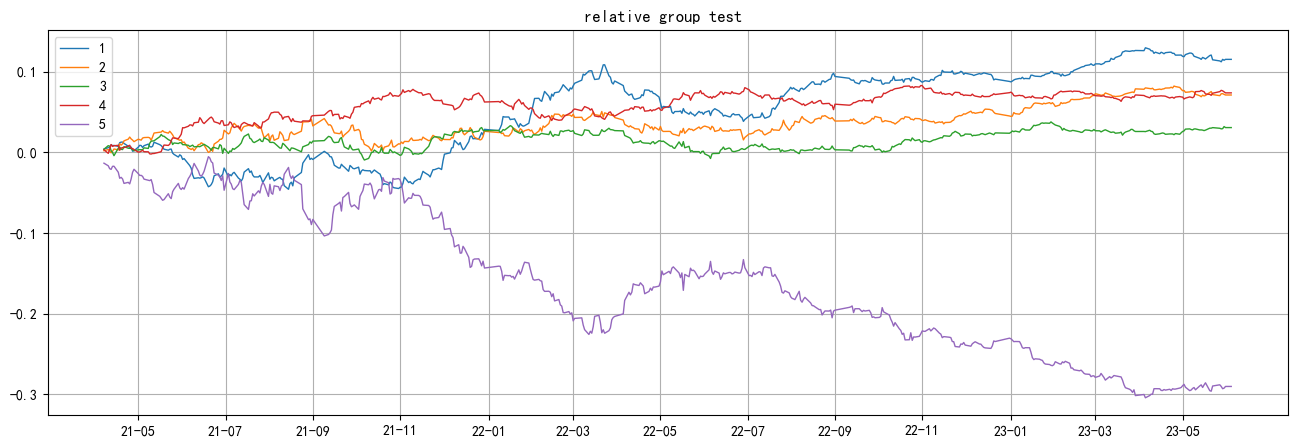

In [16]:
look(df_rank,'factor','r_1',thresh=0.01, div_num=20)
analyse_ic(df_rank,'factor','r_1')    
analyse_group_new(df_rank,'factor','r_1',is_alpha=False,num_group=5)
analyse_group_new(df_rank,'factor','r_1',is_alpha=True,num_group=5)

### factor2 is conversion_premium

In [141]:
factor2='conversion_premium'
df_rank=new_factor(factor1,factor2,data)
df_rank=pd.merge(df_rank,df[['date','order_book_id','close',factor1,'conversion_value','conversion_premium','put_trigger_price','yield_to_maturity','pb_ratio','r_1']],on=['date','order_book_id'],how='left')
df_rank

date order_book_id  factor       r_2    close  price_diff_20  \
0       2021-05-07   110031.XSHG   204.0  0.001126  106.680      -0.068770   
1       2021-05-07   110033.XSHG    24.0  0.002114  109.420      -9.100209   
2       2021-05-07   110034.XSHG    48.0 -0.002929  109.010      -7.960988   
3       2021-05-07   110038.XSHG    88.0  0.000957  104.900      -7.487085   
4       2021-05-07   110041.XSHG    17.0  0.008352  106.450     -52.085737   
...            ...           ...     ...       ...      ...            ...   
199301  2023-07-04   128140.XSHE    86.0 -0.004350  189.792     -78.781033   
199302  2023-07-04   128141.XSHE    10.0  0.004282  123.880     -41.616005   
199303  2023-07-04   128142.XSHE   276.0  0.015199  122.841     -57.145875   
199304  2023-07-04   128143.XSHE   186.0 -0.052785  130.871     -59.144454   
199305  2023-07-04   128144.XSHE   156.0  0.002261  115.089     -43.976858   

        conversion_value  conversion_premium  put_trigger_price  \
0              53.942486            0.977662             15.092   
1              97.493036            0.122337              5.026   
2              91.539301            0.190855             12.824   
3              79.035639            0.327249             11.925   
4              89.962825            0.183267              1.883   
...                  ...                 ...                ...   
199301        166.782274            0.137963             18.165   
199302        104.152933            0.189405             10.619   
199303         79.967249            0.536141             12.824   
199304         98.574822            0.327631              8.841   
199305         84.840183            0.356539              7.665   

        yield_to_maturity  pb_ratio       r_1  
0               -0.102643  1.858019  0.001687  
1               -0.041457  0.565588  0.000183  
2               -0.034542  1.420582 -0.003474  
3                0.006936  2.007766 -0.002002  
4                0.003578  0.937568  0.001784  
...                   ...       ...       ...  
199301          -0.160553  2.235021  0.000000  
199302          -0.047349  1.083574  0.000000  
199303          -0.044953  5.107115  0.000000  
199304          -0.057224  3.483303  0.000000  
199305          -0.027008  1.203502  0.000000  

[199306 rows x 12 columns]

<Figure size 1500x1200 with 0 Axes>

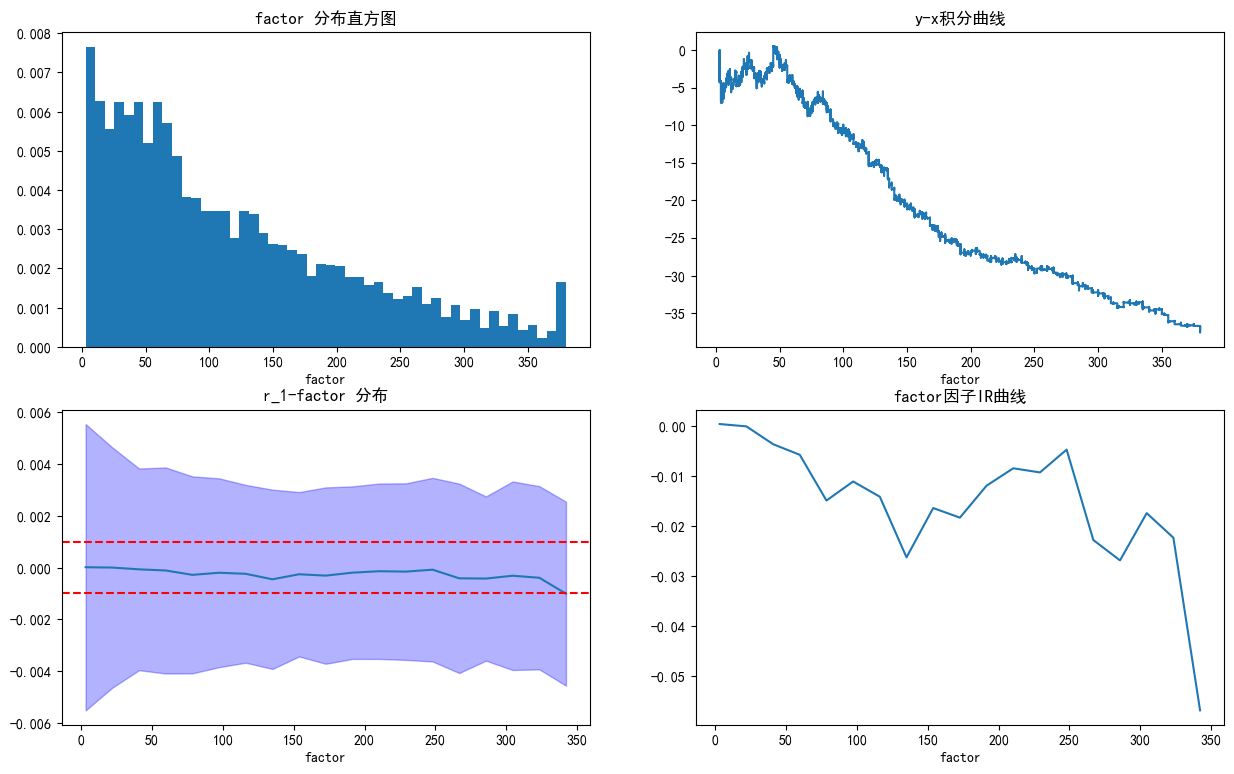

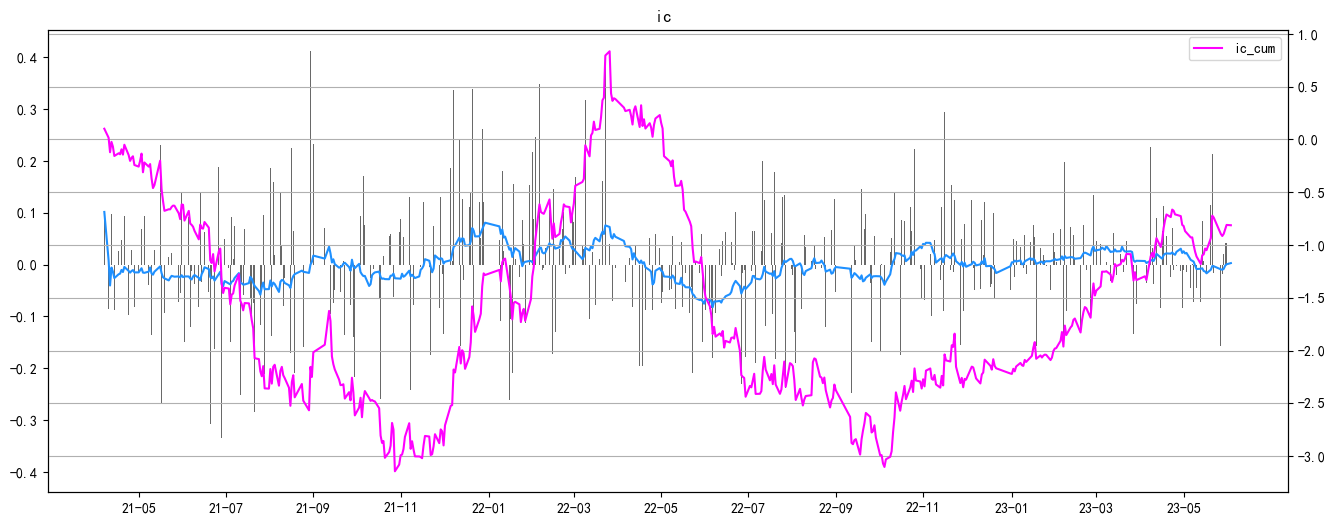

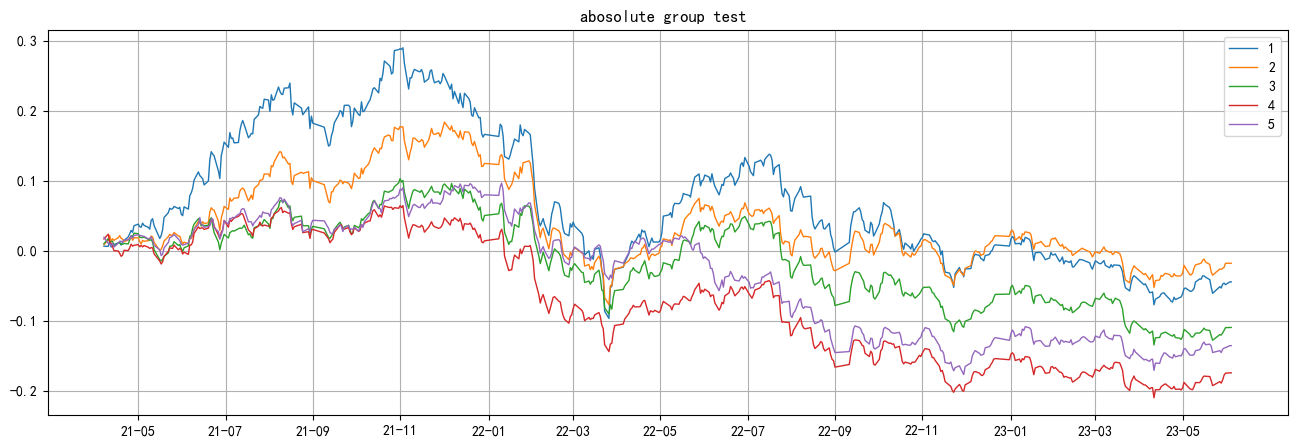

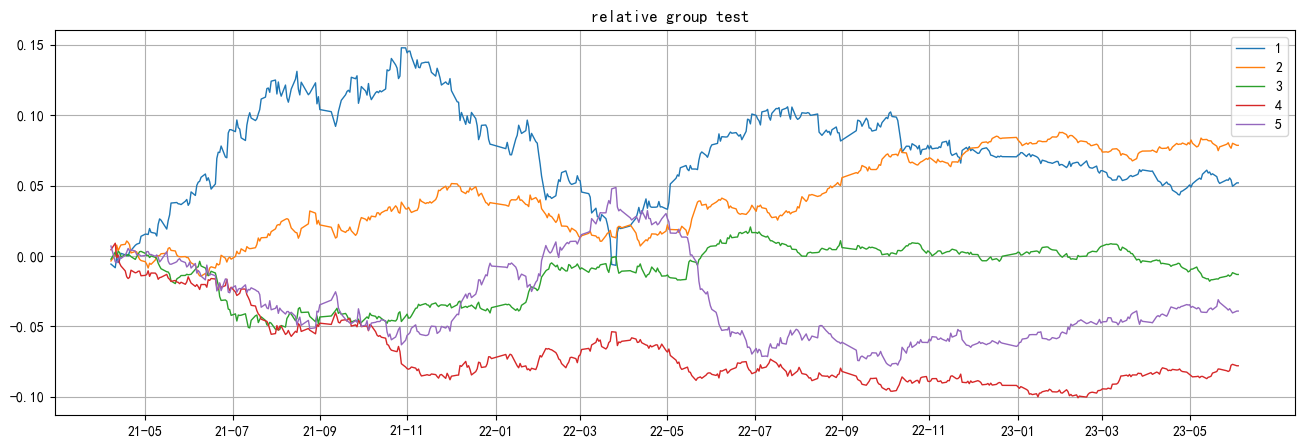

In [142]:
look(df_rank,'factor','r_1',thresh=0.01, div_num=20)
analyse_ic(df_rank,'factor','r_1')    
analyse_group_new(df_rank,'factor','r_1',is_alpha=False,num_group=5)
analyse_group_new(df_rank,'factor','r_1',is_alpha=True,num_group=5)

### factor2 is pb_ratio

In [144]:
factor2='pb_ratio'
df_rank=new_factor(factor1,factor2,data)
df_rank=pd.merge(df_rank,df[['date','order_book_id','close',factor1,'conversion_value','conversion_premium','put_trigger_price','yield_to_maturity','pb_ratio','r_1']],on=['date','order_book_id'],how='left')
df_rank

date order_book_id  factor       r_2    close  price_diff_20  \
0       2021-05-07   110031.XSHG    88.0  0.001126  106.680      -0.068770   
1       2021-05-07   110033.XSHG     4.0  0.002114  109.420      -9.100209   
2       2021-05-07   110034.XSHG    56.0 -0.002929  109.010      -7.960988   
3       2021-05-07   110038.XSHG   120.0  0.000957  104.900      -7.487085   
4       2021-05-07   110041.XSHG     3.0  0.008352  106.450     -52.085737   
...            ...           ...     ...       ...      ...            ...   
199301  2023-07-04   128140.XSHE    80.0 -0.004350  189.792     -78.781033   
199302  2023-07-04   128141.XSHE    13.0  0.004282  123.880     -41.616005   
199303  2023-07-04   128142.XSHE   261.0  0.015199  122.841     -57.145875   
199304  2023-07-04   128143.XSHE   207.0 -0.052785  130.871     -59.144454   
199305  2023-07-04   128144.XSHE    68.0  0.002261  115.089     -43.976858   

        conversion_value  conversion_premium  put_trigger_price  \
0              53.942486            0.977662             15.092   
1              97.493036            0.122337              5.026   
2              91.539301            0.190855             12.824   
3              79.035639            0.327249             11.925   
4              89.962825            0.183267              1.883   
...                  ...                 ...                ...   
199301        166.782274            0.137963             18.165   
199302        104.152933            0.189405             10.619   
199303         79.967249            0.536141             12.824   
199304         98.574822            0.327631              8.841   
199305         84.840183            0.356539              7.665   

        yield_to_maturity  pb_ratio       r_1  
0               -0.102643  1.858019  0.001687  
1               -0.041457  0.565588  0.000183  
2               -0.034542  1.420582 -0.003474  
3                0.006936  2.007766 -0.002002  
4                0.003578  0.937568  0.001784  
...                   ...       ...       ...  
199301          -0.160553  2.235021  0.000000  
199302          -0.047349  1.083574  0.000000  
199303          -0.044953  5.107115  0.000000  
199304          -0.057224  3.483303  0.000000  
199305          -0.027008  1.203502  0.000000  

[199306 rows x 12 columns]

<Figure size 1500x1200 with 0 Axes>

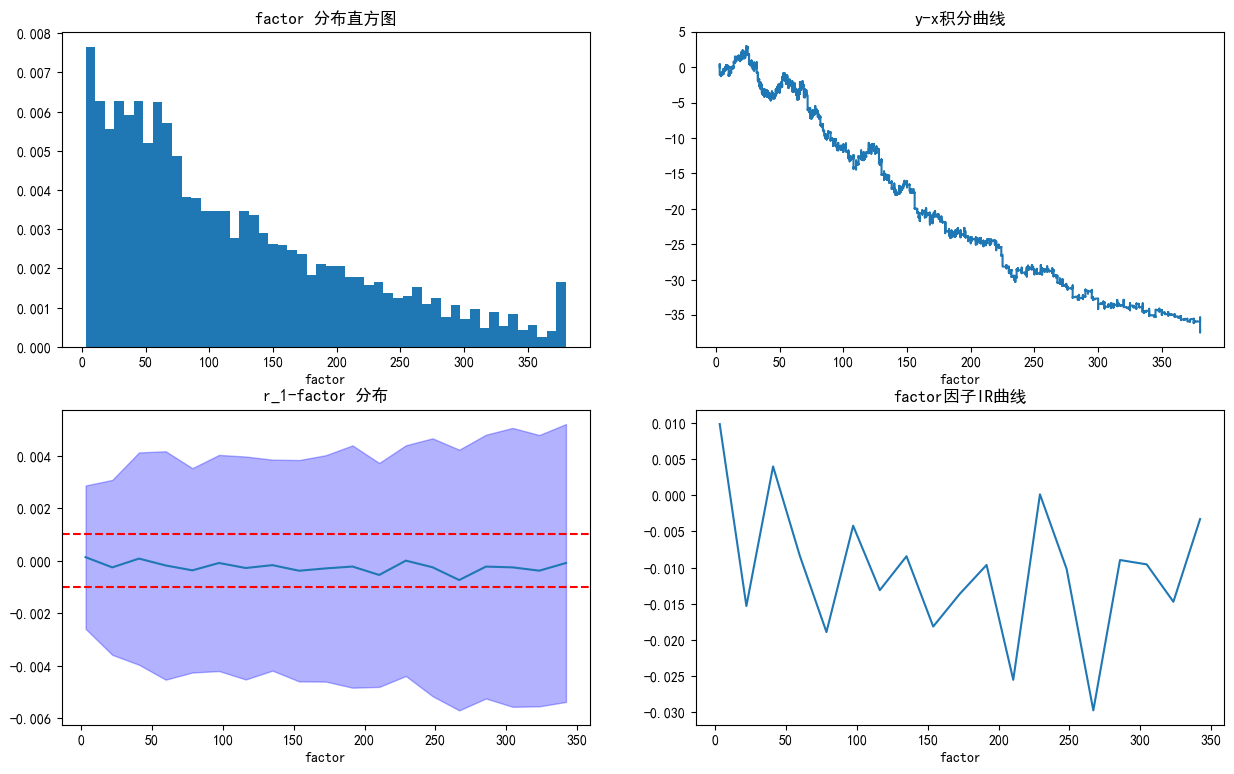

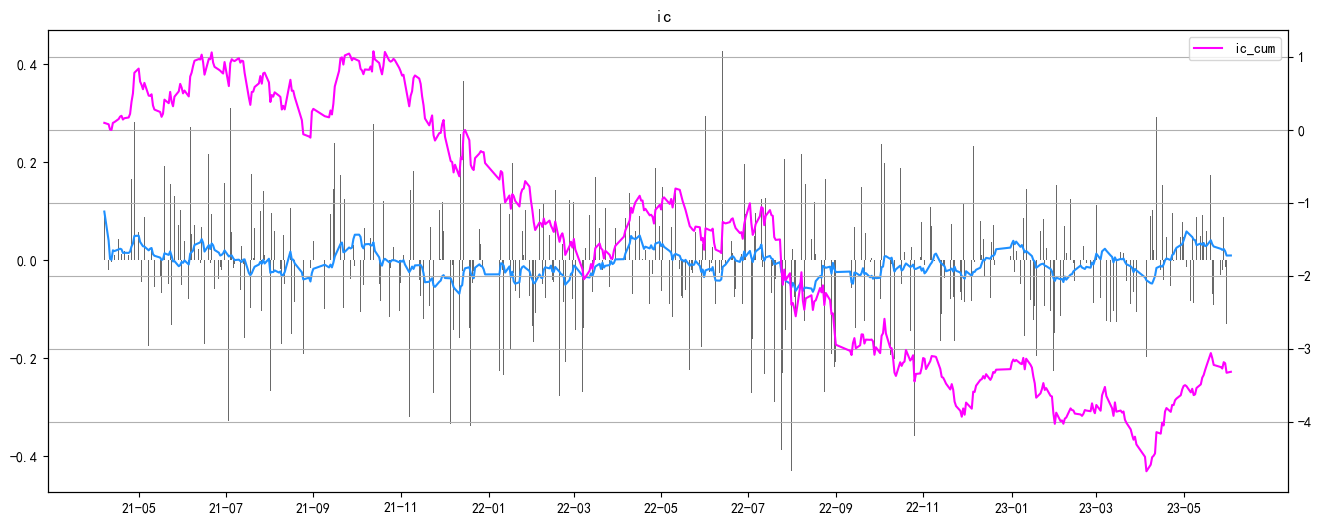

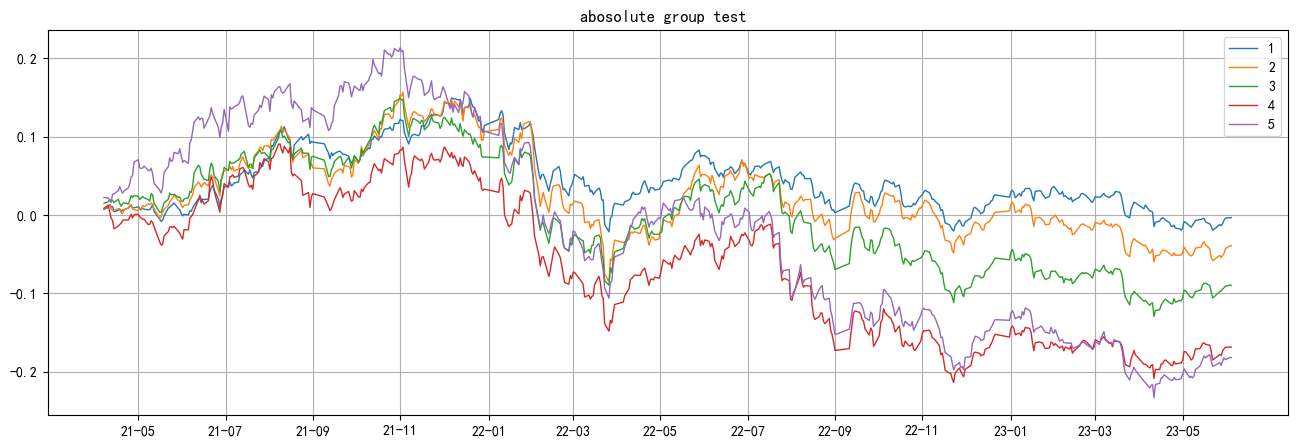

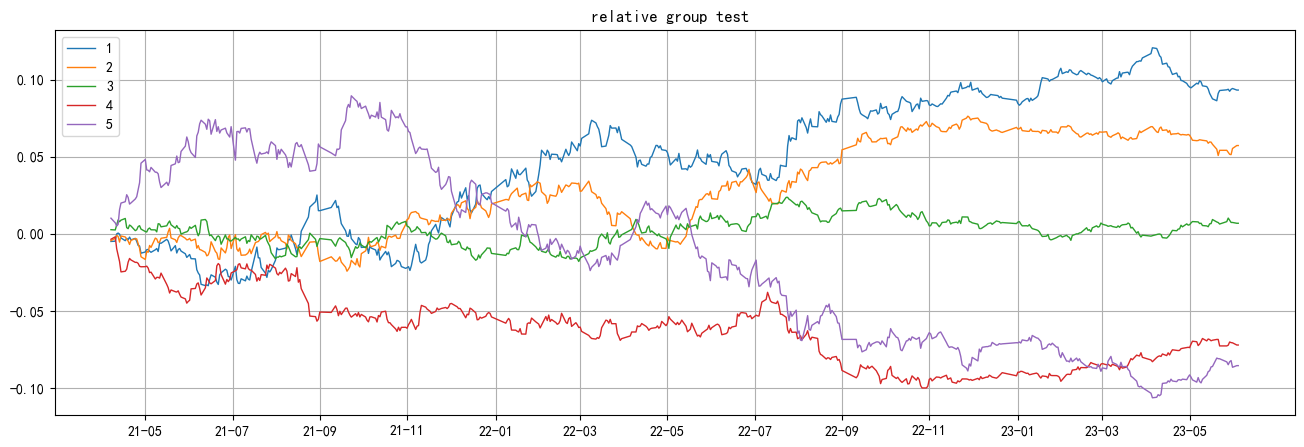

In [145]:
look(df_rank,'factor','r_1',thresh=0.01, div_num=20)
analyse_ic(df_rank,'factor','r_1')    
analyse_group_new(df_rank,'factor','r_1',is_alpha=False,num_group=5)
analyse_group_new(df_rank,'factor','r_1',is_alpha=True,num_group=5)

### factor2 is put_trigger_price

In [147]:
factor2='put_trigger_price'
df_rank=new_factor(factor1,factor2,data)
df_rank=pd.merge(df_rank,df[['date','order_book_id','close',factor1,'conversion_value','conversion_premium','put_trigger_price','yield_to_maturity','pb_ratio','r_1']],on=['date','order_book_id'],how='left')
df_rank

date order_book_id  factor       r_2    close  price_diff_20  \
0       2021-05-07   110031.XSHG   188.0  0.001126  106.680      -0.068770   
1       2021-05-07   110033.XSHG    48.0  0.002114  109.420      -9.100209   
2       2021-05-07   110034.XSHG   152.0 -0.002929  109.010      -7.960988   
3       2021-05-07   110038.XSHG   144.0  0.000957  104.900      -7.487085   
4       2021-05-07   110041.XSHG     1.0  0.008352  106.450     -52.085737   
...            ...           ...     ...       ...      ...            ...   
199301  2023-07-04   128140.XSHE   170.0 -0.004350  189.792     -78.781033   
199302  2023-07-04   128141.XSHE    35.0  0.004282  123.880     -41.616005   
199303  2023-07-04   128142.XSHE   177.0  0.015199  122.841     -57.145875   
199304  2023-07-04   128143.XSHE   111.0 -0.052785  130.871     -59.144454   
199305  2023-07-04   128144.XSHE   148.0  0.002261  115.089     -43.976858   

        conversion_value  conversion_premium  put_trigger_price  \
0              53.942486            0.977662             15.092   
1              97.493036            0.122337              5.026   
2              91.539301            0.190855             12.824   
3              79.035639            0.327249             11.925   
4              89.962825            0.183267              1.883   
...                  ...                 ...                ...   
199301        166.782274            0.137963             18.165   
199302        104.152933            0.189405             10.619   
199303         79.967249            0.536141             12.824   
199304         98.574822            0.327631              8.841   
199305         84.840183            0.356539              7.665   

        yield_to_maturity  pb_ratio       r_1  
0               -0.102643  1.858019  0.001687  
1               -0.041457  0.565588  0.000183  
2               -0.034542  1.420582 -0.003474  
3                0.006936  2.007766 -0.002002  
4                0.003578  0.937568  0.001784  
...                   ...       ...       ...  
199301          -0.160553  2.235021  0.000000  
199302          -0.047349  1.083574  0.000000  
199303          -0.044953  5.107115  0.000000  
199304          -0.057224  3.483303  0.000000  
199305          -0.027008  1.203502  0.000000  

[199306 rows x 12 columns]

<Figure size 1500x1200 with 0 Axes>

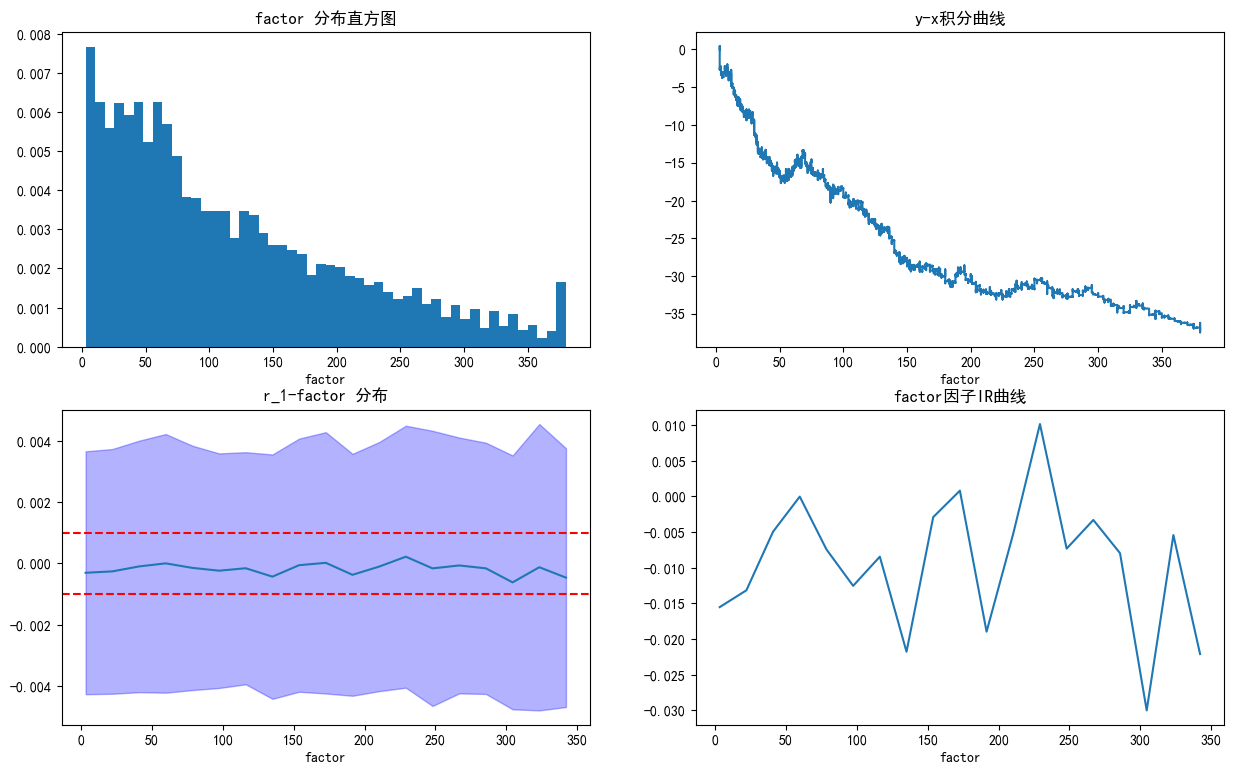

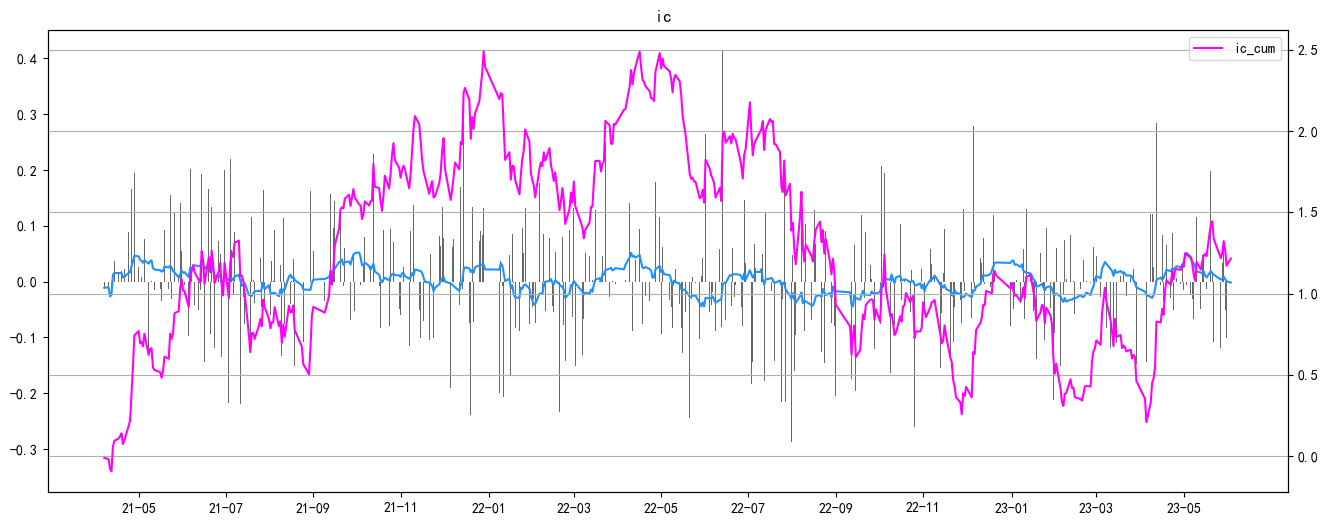

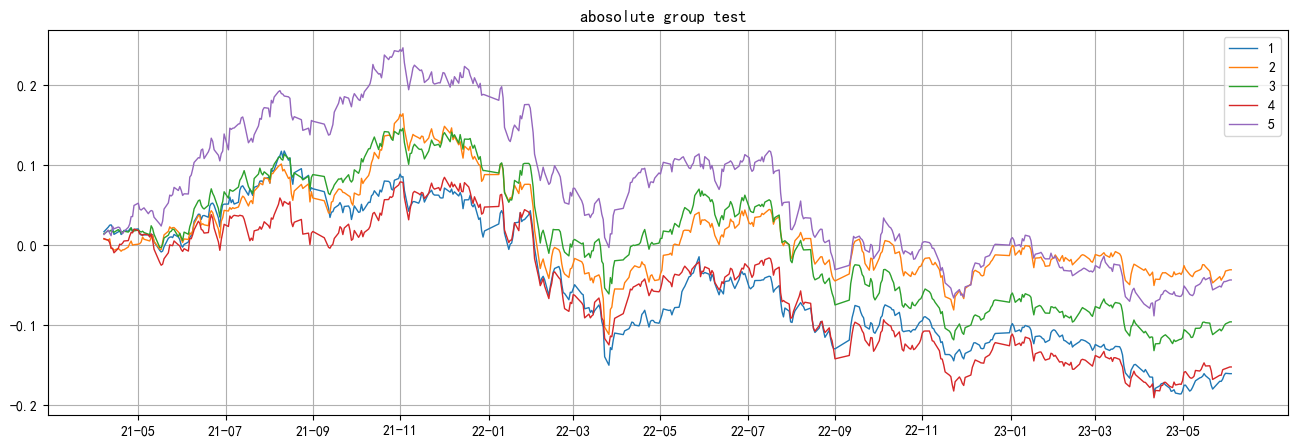

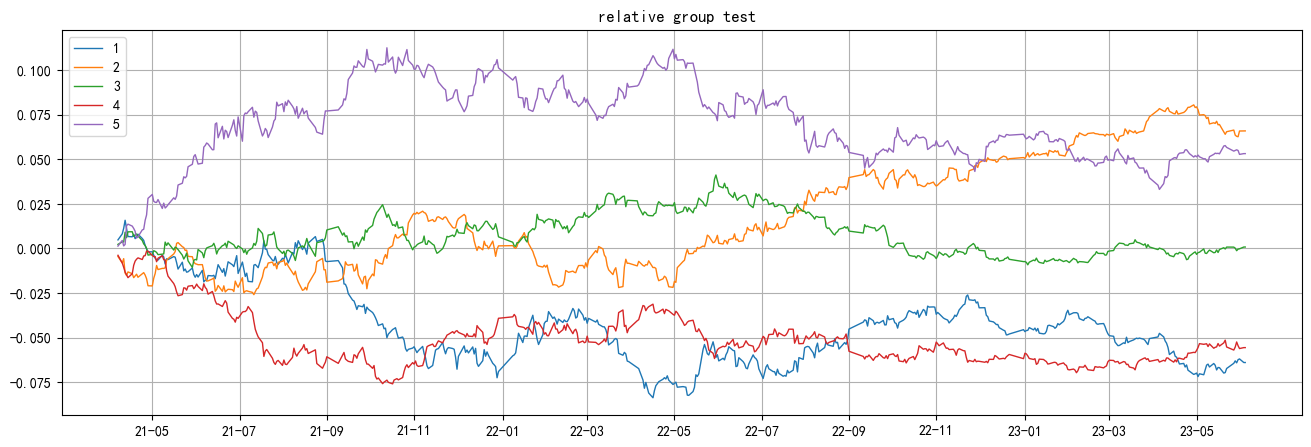

In [148]:
look(df_rank,'factor','r_1',thresh=0.01, div_num=20)
analyse_ic(df_rank,'factor','r_1')    
analyse_group_new(df_rank,'factor','r_1',is_alpha=False,num_group=5)
analyse_group_new(df_rank,'factor','r_1',is_alpha=True,num_group=5)

### factor2 is yield_to_maturity

In [26]:
factor2='yield_to_maturity'
df_rank=new_factor(factor1,factor2,data)
df_rank=pd.merge(df_rank,df[['date','order_book_id','close',factor1,'conversion_value','conversion_premium','put_trigger_price','yield_to_maturity','pb_ratio','r_1']],on=['date','order_book_id'],how='left')
df_rank

date order_book_id  factor       r_2    close  price_diff_20  \
0       2021-05-07   110031.XSHG    60.0  0.001126  106.680      -0.068770   
1       2021-05-07   110033.XSHG    72.0  0.002114  109.420      -9.100209   
2       2021-05-07   110034.XSHG    76.0 -0.002929  109.010      -7.960988   
3       2021-05-07   110038.XSHG   112.0  0.000957  104.900      -7.487085   
4       2021-05-07   110041.XSHG    18.0  0.008352  106.450     -52.085737   
...            ...           ...     ...       ...      ...            ...   
199301  2023-07-04   128140.XSHE    54.0 -0.004350  189.792     -78.781033   
199302  2023-07-04   128141.XSHE    16.0  0.004282  123.880     -41.616005   
199303  2023-07-04   128142.XSHE   141.0  0.015199  122.841     -57.145875   
199304  2023-07-04   128143.XSHE    99.0 -0.052785  130.871     -59.144454   
199305  2023-07-04   128144.XSHE   260.0  0.002261  115.089     -43.976858   

        conversion_value  conversion_premium  put_trigger_price  \
0              53.942486            0.977662             15.092   
1              97.493036            0.122337              5.026   
2              91.539301            0.190855             12.824   
3              79.035639            0.327249             11.925   
4              89.962825            0.183267              1.883   
...                  ...                 ...                ...   
199301        166.782274            0.137963             18.165   
199302        104.152933            0.189405             10.619   
199303         79.967249            0.536141             12.824   
199304         98.574822            0.327631              8.841   
199305         84.840183            0.356539              7.665   

        yield_to_maturity  pb_ratio       r_1  
0               -0.102643  1.858019  0.001312  
1               -0.041457  0.565588 -0.001828  
2               -0.034542  1.420582 -0.003383  
3                0.006936  2.007766 -0.002097  
4                0.003578  0.937568  0.001784  
...                   ...       ...       ...  
199301          -0.160553  2.235021  0.000000  
199302          -0.047349  1.083574  0.000000  
199303          -0.044953  5.107115  0.000000  
199304          -0.057224  3.483303  0.000000  
199305          -0.027008  1.203502  0.000000  

[199306 rows x 12 columns]

<Figure size 1500x1200 with 0 Axes>

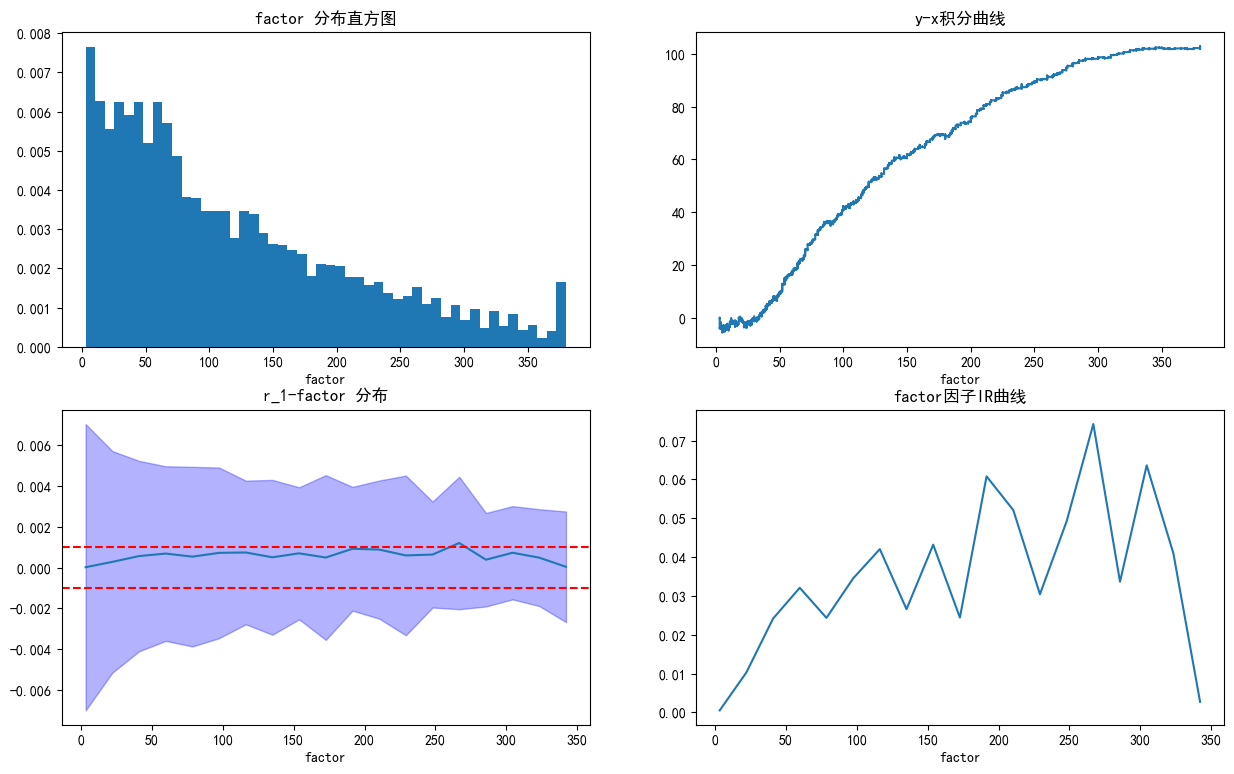

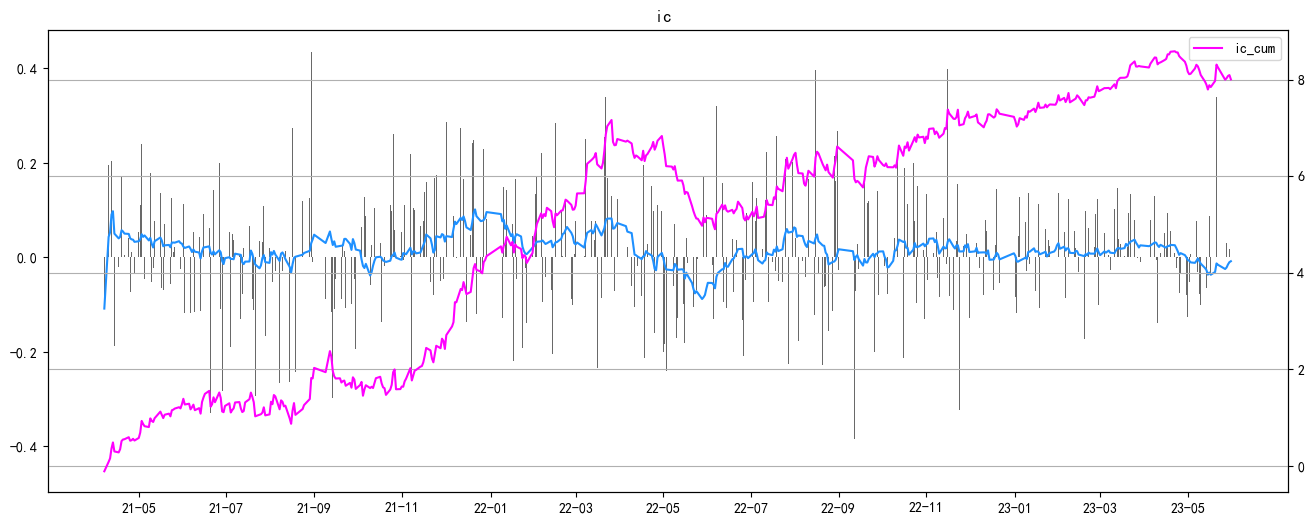

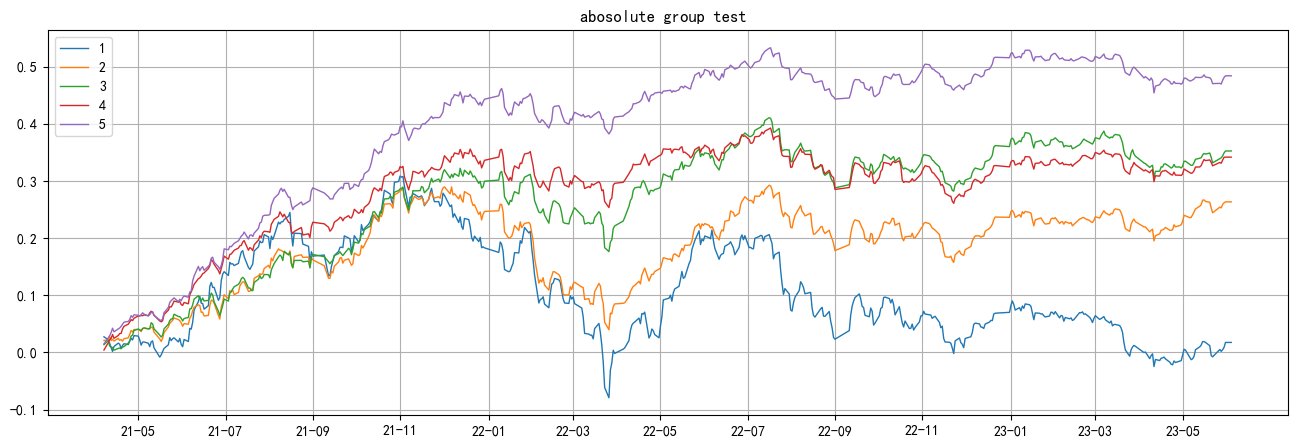

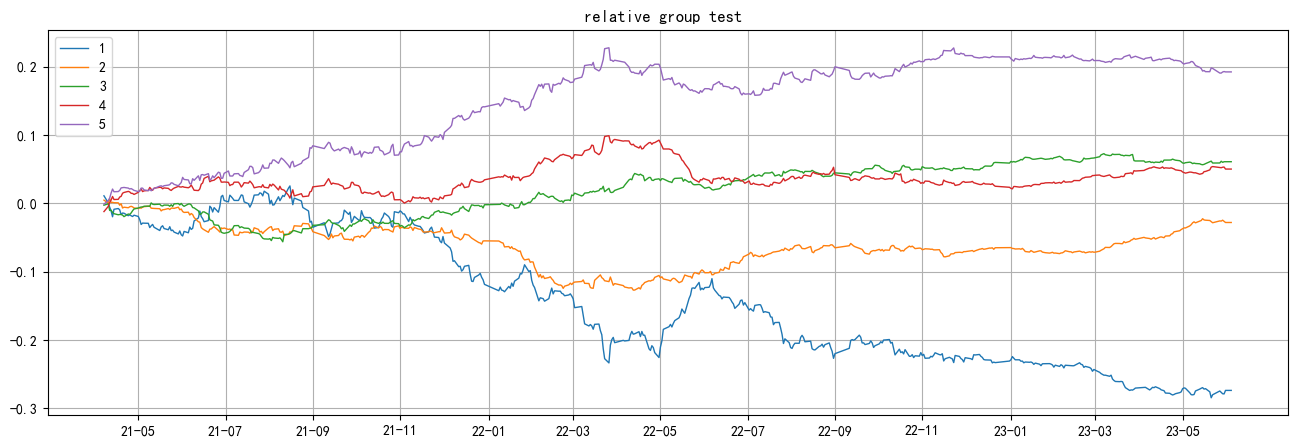

In [27]:
look(df_rank,'factor','r_1',thresh=0.01, div_num=20)
analyse_ic(df_rank,'factor','r_1')    
analyse_group_new(df_rank,'factor','r_1',is_alpha=False,num_group=5)
analyse_group_new(df_rank,'factor','r_1',is_alpha=True,num_group=5)

In [19]:
factor1='close'
factor2='conversion_value'
df_rank=new_factor(factor1,factor2,data)
df_rank=pd.merge(df_rank,df[['date','order_book_id','close','conversion_value','conversion_premium','put_trigger_price','yield_to_maturity','pb_ratio','r_1']],on=['date','order_book_id'],how='left')
df_rank

date order_book_id  factor       r_2    close  conversion_value  \
0       2021-05-07   110031.XSHG     1.0  0.001126  106.680         53.942486   
1       2021-05-07   110033.XSHG    45.0  0.002114  109.420         97.493036   
2       2021-05-07   110034.XSHG    35.0 -0.002929  109.010         91.539301   
3       2021-05-07   110038.XSHG    11.0  0.000957  104.900         79.035639   
4       2021-05-07   110041.XSHG    29.0  0.008352  106.450         89.962825   
...            ...           ...     ...       ...      ...               ...   
199330  2023-07-04   128140.XSHE   340.0 -0.004350  189.792        166.782274   
199331  2023-07-04   128141.XSHE   252.0  0.004282  123.880        104.152933   
199332  2023-07-04   128142.XSHE    48.0  0.015199  122.841         79.967249   
199333  2023-07-04   128143.XSHE    27.0 -0.052785  130.871         98.574822   
199334  2023-07-04   128144.XSHE   268.0  0.002261  115.089         84.840183   

        conversion_premium  put_trigger_price  yield_to_maturity  pb_ratio  \
0                 0.977662             15.092          -0.102643  1.858019   
1                 0.122337              5.026          -0.041457  0.565588   
2                 0.190855             12.824          -0.034542  1.420582   
3                 0.327249             11.925           0.006936  2.007766   
4                 0.183267              1.883           0.003578  0.937568   
...                    ...                ...                ...       ...   
199330            0.137963             18.165          -0.160553  2.235021   
199331            0.189405             10.619          -0.047349  1.083574   
199332            0.536141             12.824          -0.044953  5.107115   
199333            0.327631              8.841          -0.057224  3.483303   
199334            0.356539              7.665          -0.027008  1.203502   

             r_1  
0       0.001123  
1       0.005026  
2      -0.000367  
3       0.003152  
4      -0.000562  
...          ...  
199330  0.000000  
199331  0.000000  
199332  0.000000  
199333  0.000000  
199334  0.000000  

[199335 rows x 11 columns]

<Figure size 1500x1200 with 0 Axes>

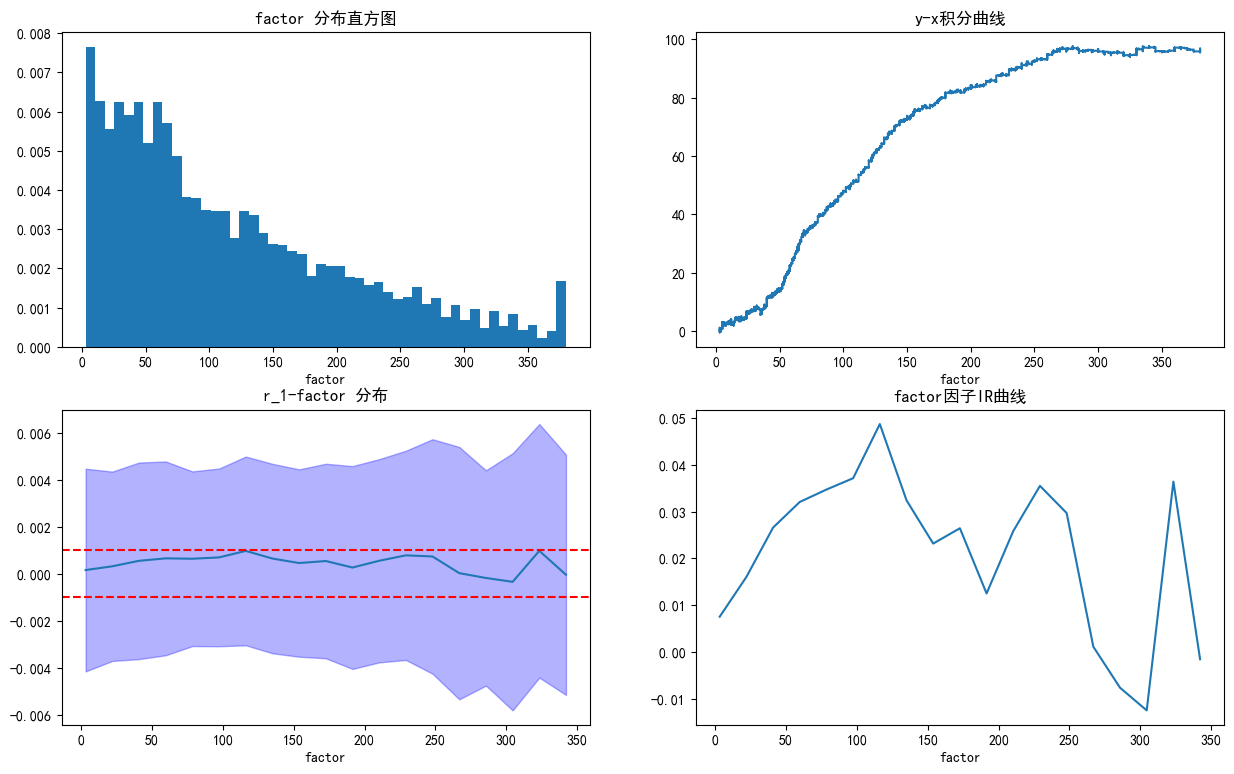

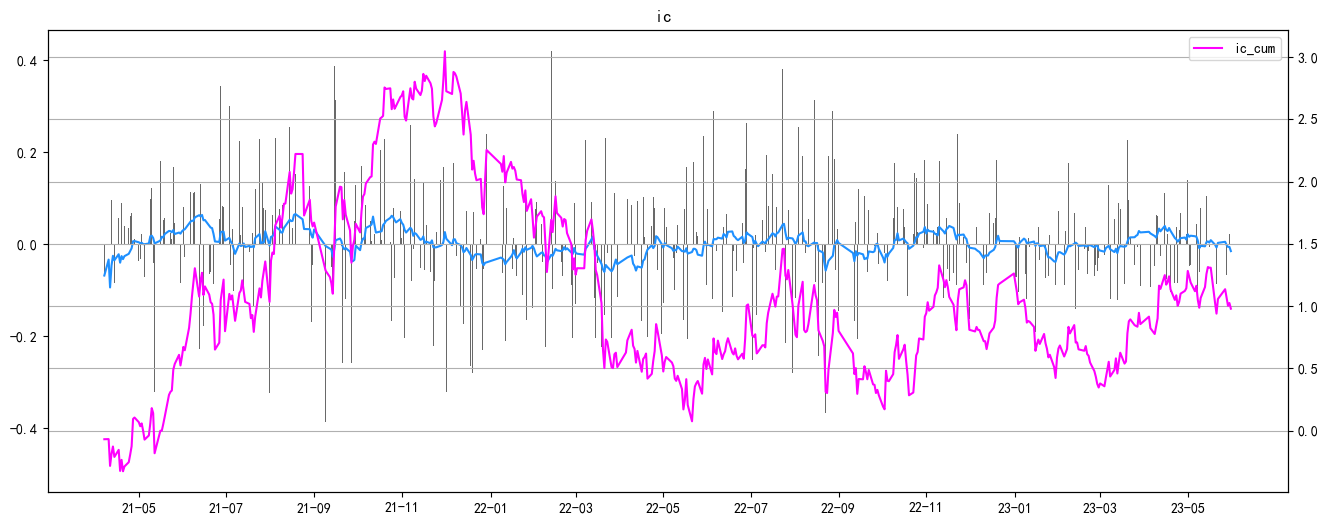

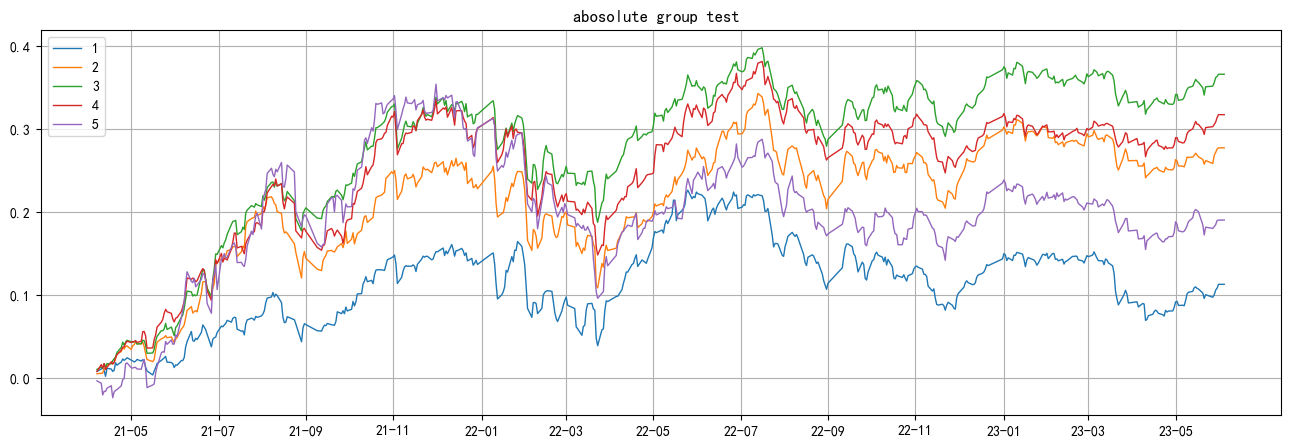

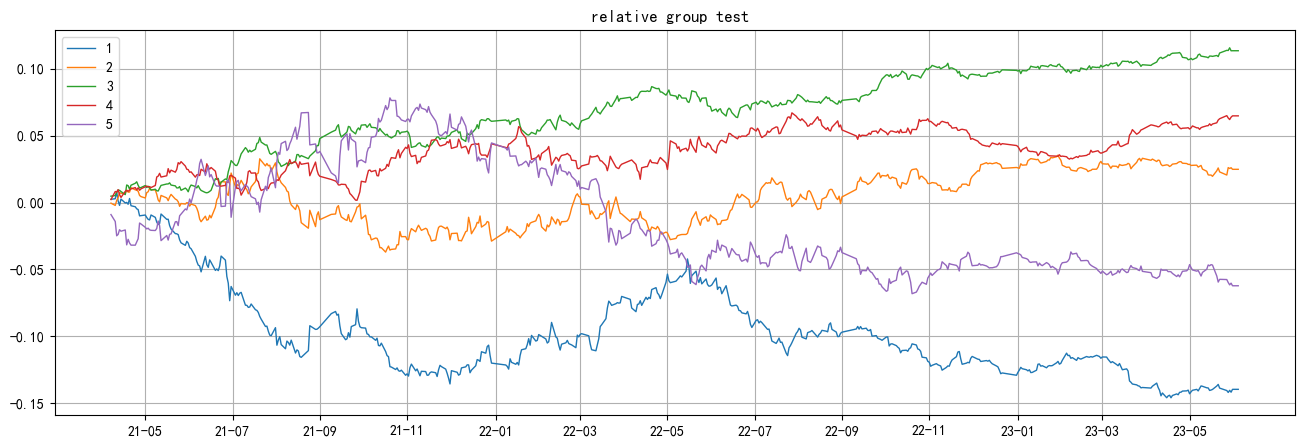

In [20]:
look(df_rank,'factor','r_1',thresh=0.01, div_num=20)
analyse_ic(df_rank,'factor','r_1')    
analyse_group_new(df_rank,'factor','r_1',is_alpha=False,num_group=5)
analyse_group_new(df_rank,'factor','r_1',is_alpha=True,num_group=5)

### factor2 is convertible_bond_momentum

In [17]:
factor2='convertible_bond_momentum'
df_rank=new_factor(factor1,factor2,data)
df_rank=pd.merge(df_rank,df[['date','order_book_id','close',factor1,'conversion_value','conversion_premium','put_trigger_price','yield_to_maturity','pb_ratio','convertible_bond_momentum','stock_momentum','r_1']],on=['date','order_book_id'],how='left')
df_rank

date order_book_id  factor       r_2    close  price_diff_20  \
0       2021-05-07   110031.XSHG   116.0  0.001126  106.680      -0.068770   
1       2021-05-07   110033.XSHG   164.0  0.002114  109.420      -9.100209   
2       2021-05-07   110034.XSHG    84.0 -0.002929  109.010      -7.960988   
3       2021-05-07   110038.XSHG   144.0  0.000957  104.900      -7.487085   
4       2021-05-07   110041.XSHG    41.0  0.008352  106.450     -52.085737   
...            ...           ...     ...       ...      ...            ...   
199301  2023-07-04   128140.XSHE   124.0 -0.004350  189.792     -78.781033   
199302  2023-07-04   128141.XSHE    35.0  0.004282  123.880     -41.616005   
199303  2023-07-04   128142.XSHE   123.0  0.015199  122.841     -57.145875   
199304  2023-07-04   128143.XSHE   282.0 -0.052785  130.871     -59.144454   
199305  2023-07-04   128144.XSHE   100.0  0.002261  115.089     -43.976858   

        conversion_value  conversion_premium  put_trigger_price  \
0              53.942486            0.977662             15.092   
1              97.493036            0.122337              5.026   
2              91.539301            0.190855             12.824   
3              79.035639            0.327249             11.925   
4              89.962825            0.183267              1.883   
...                  ...                 ...                ...   
199301        166.782274            0.137963             18.165   
199302        104.152933            0.189405             10.619   
199303         79.967249            0.536141             12.824   
199304         98.574822            0.327631              8.841   
199305         84.840183            0.356539              7.665   

        yield_to_maturity  pb_ratio  convertible_bond_momentum  \
0               -0.102643  1.858019                   0.000469   
1               -0.041457  0.565588                   0.005329   
2               -0.034542  1.420582                  -0.003656   
3                0.006936  2.007766                   0.003540   
4                0.003578  0.937568                   0.008527   
...                   ...       ...                        ...   
199301          -0.160553  2.235021                   0.021546   
199302          -0.047349  1.083574                   0.003646   
199303          -0.044953  5.107115                   0.011512   
199304          -0.057224  3.483303                   0.076764   
199305          -0.027008  1.203502                   0.001227   

        stock_momentum       r_1  
0            -0.030026  0.001312  
1             0.014484 -0.001828  
2            -0.017574 -0.003383  
3            -0.023820 -0.002097  
4             0.025389  0.001784  
...                ...       ...  
199301        0.069963  0.000000  
199302        0.009585  0.000000  
199303       -0.017438  0.000000  
199304        0.114593  0.000000  
199305        0.041480  0.000000  

[199306 rows x 14 columns]

<Figure size 1500x1200 with 0 Axes>

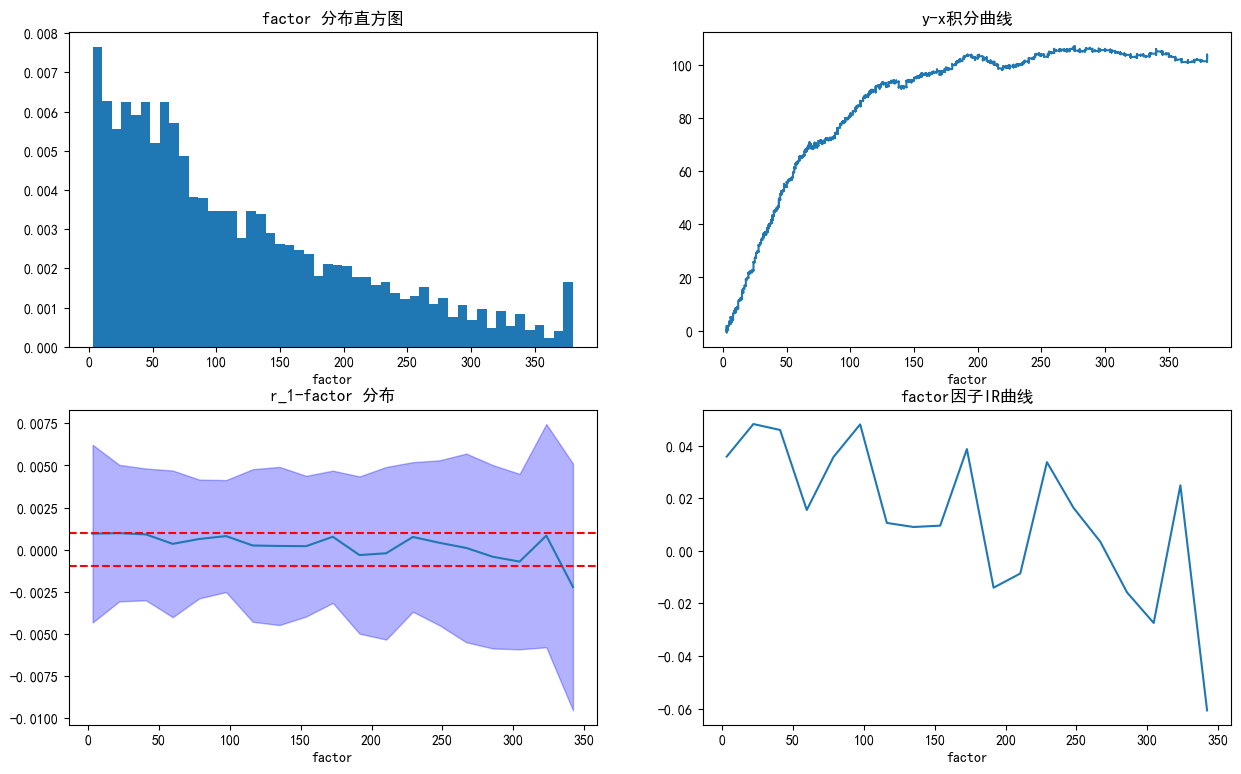

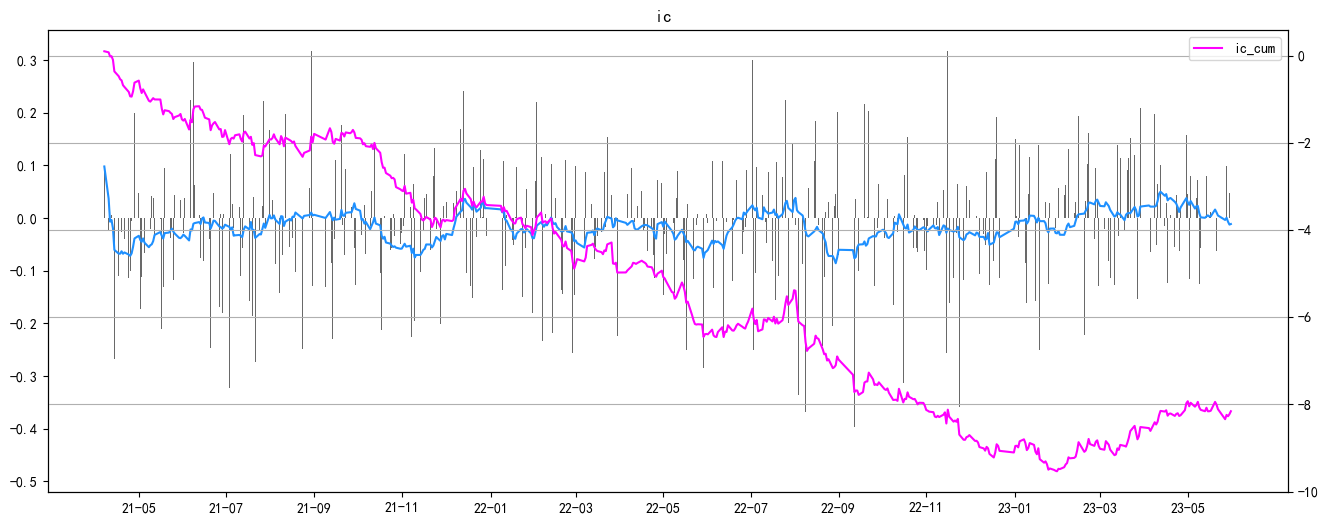

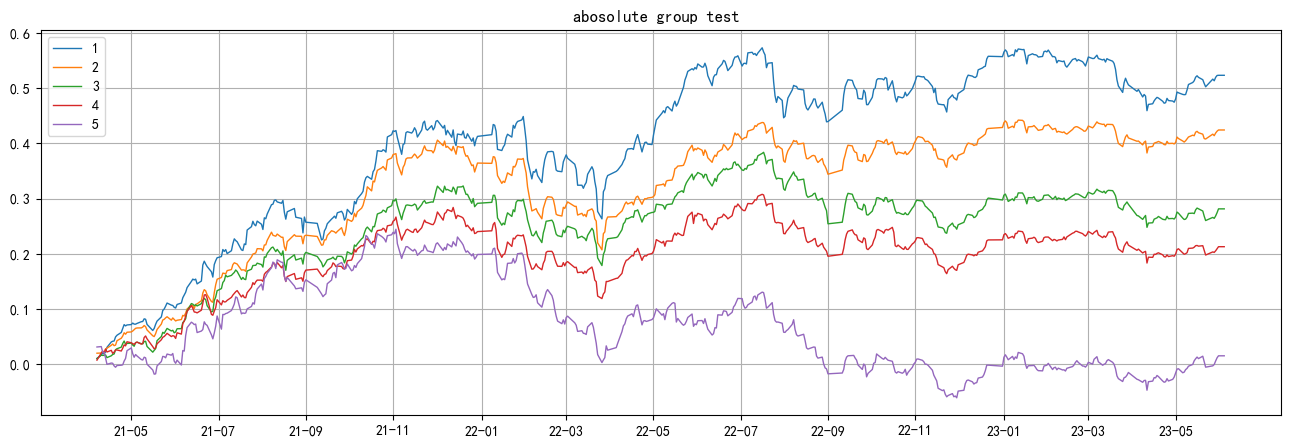

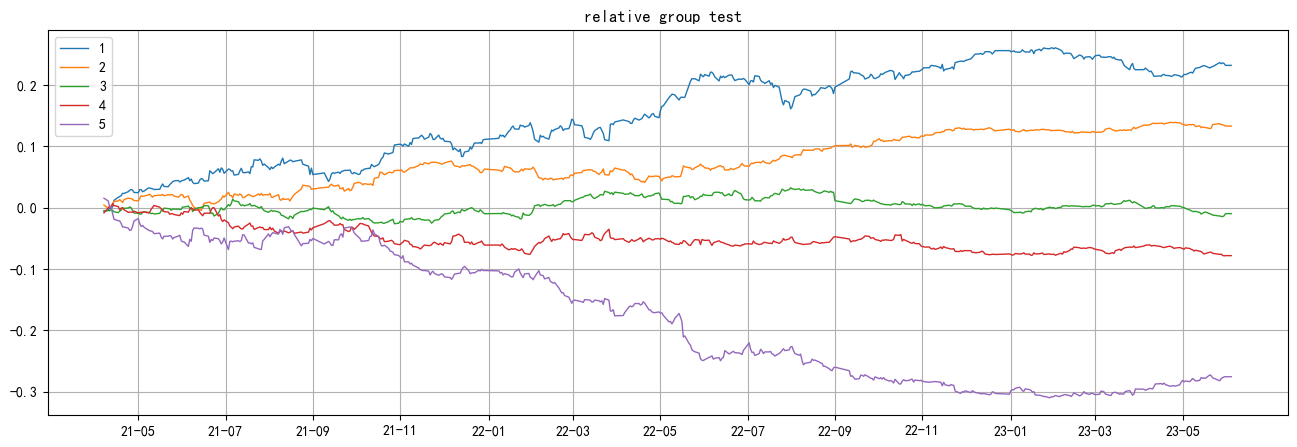

In [18]:
look(df_rank,'factor','r_1',thresh=0.01, div_num=20)
analyse_ic(df_rank,'factor','r_1')    
analyse_group_new(df_rank,'factor','r_1',is_alpha=False,num_group=5)
analyse_group_new(df_rank,'factor','r_1',is_alpha=True,num_group=5)

### factor2 is stock_momentum

In [19]:
factor2='stock_momentum'
df_rank=new_factor(factor1,factor2,data)
df_rank=pd.merge(df_rank,df[['date','order_book_id','close',factor1,'conversion_value','conversion_premium','put_trigger_price','yield_to_maturity','pb_ratio','convertible_bond_momentum','stock_momentum','r_1']],on=['date','order_book_id'],how='left')
df_rank

date order_book_id  factor       r_2    close  price_diff_20  \
0       2021-05-07   110031.XSHG   100.0  0.001126  106.680      -0.068770   
1       2021-05-07   110033.XSHG   196.0  0.002114  109.420      -9.100209   
2       2021-05-07   110034.XSHG   128.0 -0.002929  109.010      -7.960988   
3       2021-05-07   110038.XSHG   112.0  0.000957  104.900      -7.487085   
4       2021-05-07   110041.XSHG    53.0  0.008352  106.450     -52.085737   
...            ...           ...     ...       ...      ...            ...   
199301  2023-07-04   128140.XSHE   146.0 -0.004350  189.792     -78.781033   
199302  2023-07-04   128141.XSHE    28.0  0.004282  123.880     -41.616005   
199303  2023-07-04   128142.XSHE    42.0  0.015199  122.841     -57.145875   
199304  2023-07-04   128143.XSHE   273.0 -0.052785  130.871     -59.144454   
199305  2023-07-04   128144.XSHE   252.0  0.002261  115.089     -43.976858   

        conversion_value  conversion_premium  put_trigger_price  \
0              53.942486            0.977662             15.092   
1              97.493036            0.122337              5.026   
2              91.539301            0.190855             12.824   
3              79.035639            0.327249             11.925   
4              89.962825            0.183267              1.883   
...                  ...                 ...                ...   
199301        166.782274            0.137963             18.165   
199302        104.152933            0.189405             10.619   
199303         79.967249            0.536141             12.824   
199304         98.574822            0.327631              8.841   
199305         84.840183            0.356539              7.665   

        yield_to_maturity  pb_ratio  convertible_bond_momentum  \
0               -0.102643  1.858019                   0.000469   
1               -0.041457  0.565588                   0.005329   
2               -0.034542  1.420582                  -0.003656   
3                0.006936  2.007766                   0.003540   
4                0.003578  0.937568                   0.008527   
...                   ...       ...                        ...   
199301          -0.160553  2.235021                   0.021546   
199302          -0.047349  1.083574                   0.003646   
199303          -0.044953  5.107115                   0.011512   
199304          -0.057224  3.483303                   0.076764   
199305          -0.027008  1.203502                   0.001227   

        stock_momentum       r_1  
0            -0.030026  0.001312  
1             0.014484 -0.001828  
2            -0.017574 -0.003383  
3            -0.023820 -0.002097  
4             0.025389  0.001784  
...                ...       ...  
199301        0.069963  0.000000  
199302        0.009585  0.000000  
199303       -0.017438  0.000000  
199304        0.114593  0.000000  
199305        0.041480  0.000000  

[199306 rows x 14 columns]

<Figure size 1500x1200 with 0 Axes>

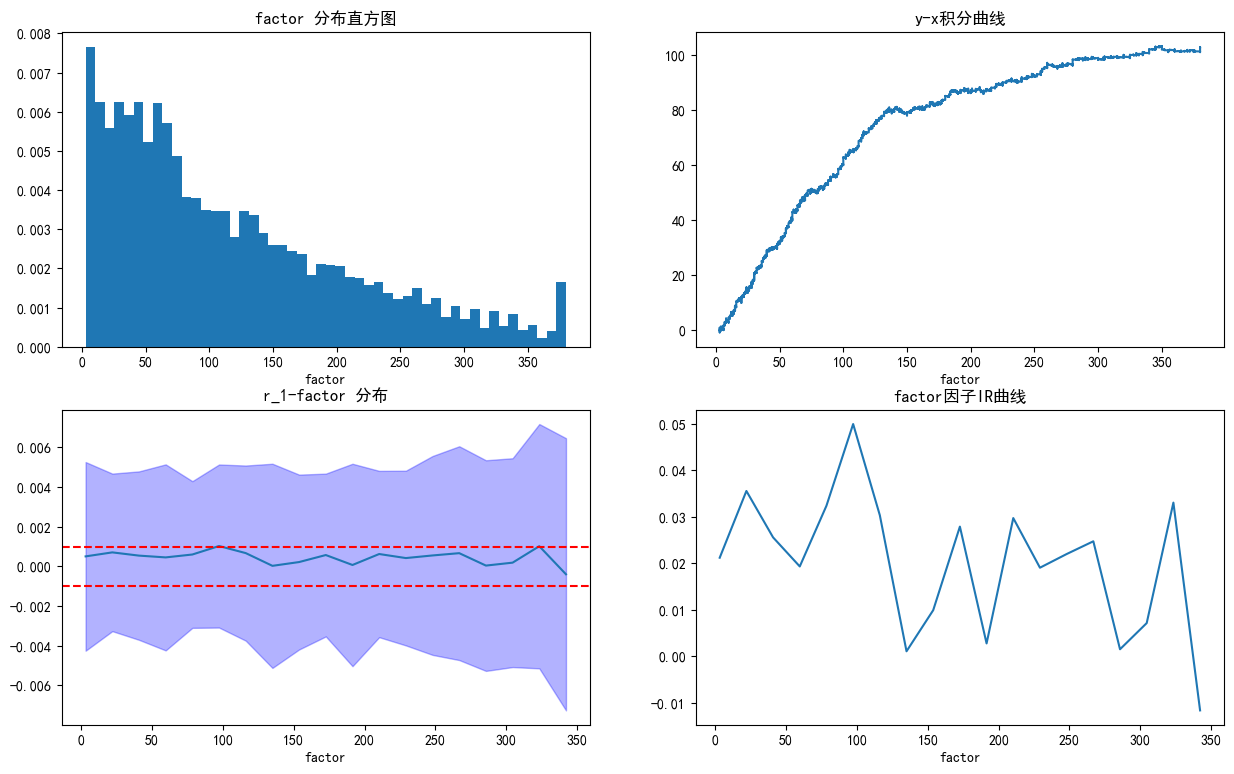

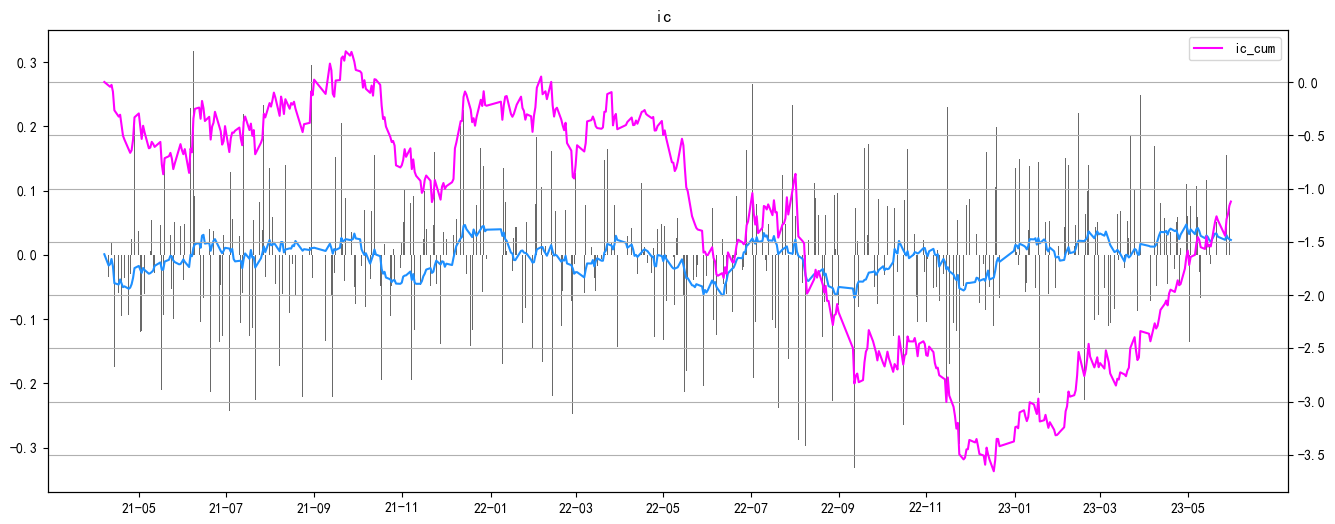

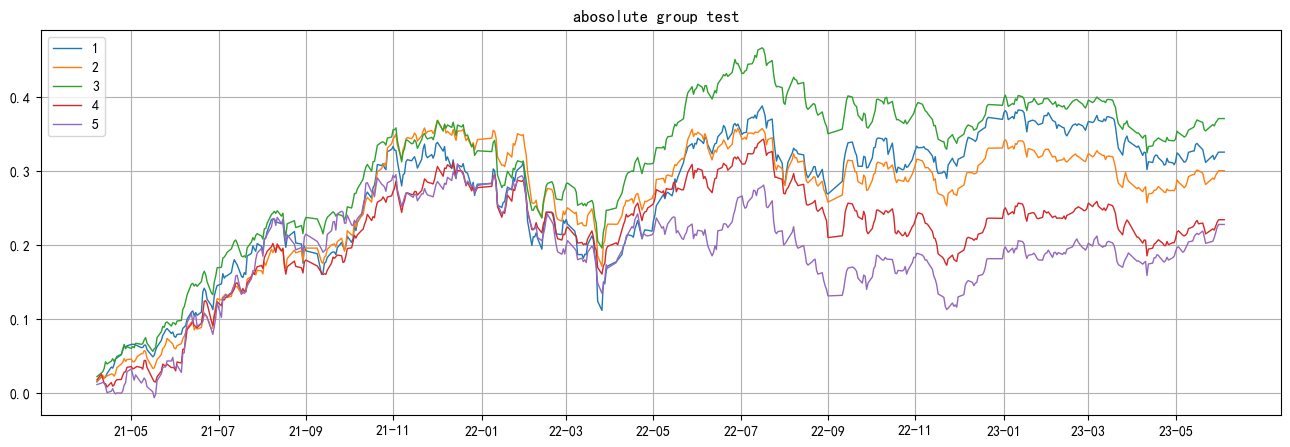

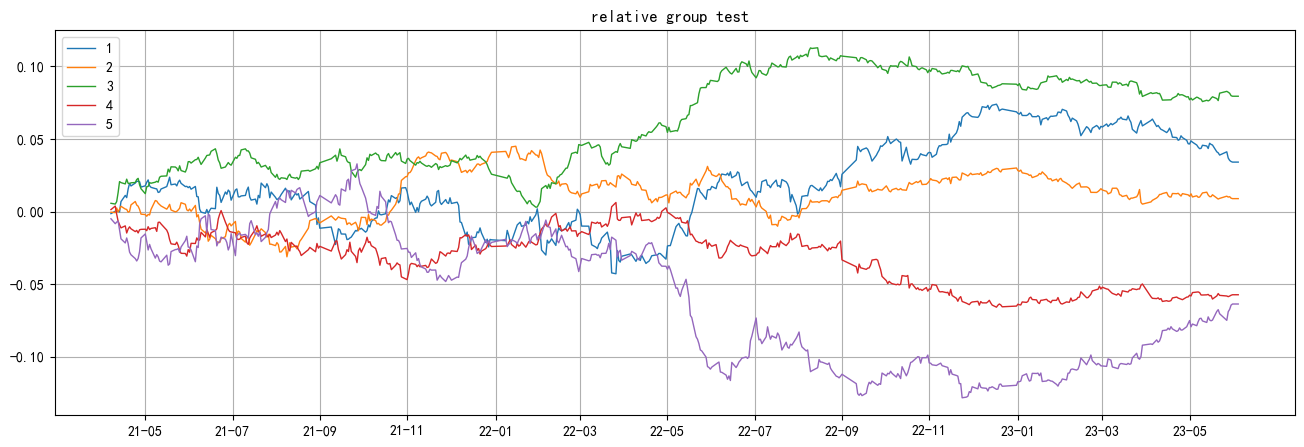

In [20]:
look(df_rank,'factor','r_1',thresh=0.01, div_num=20)
analyse_ic(df_rank,'factor','r_1')    
analyse_group_new(df_rank,'factor','r_1',is_alpha=False,num_group=5)
analyse_group_new(df_rank,'factor','r_1',is_alpha=True,num_group=5)

### factor2 is 'turnover_rate'

In [23]:
factor2='turnover_rate'
df_rank=new_factor(factor1,factor2,data)
df_rank=pd.merge(df_rank,df[['date','order_book_id','close',factor1,'conversion_value','conversion_premium','put_trigger_price','yield_to_maturity','pb_ratio','convertible_bond_momentum','stock_momentum','turnover_rate','r_1']],on=['date','order_book_id'],how='left')
df_rank

date order_book_id  factor       r_2    close  price_diff_20  \
0       2021-05-07   110031.XSHG    12.0  0.001126  106.680      -0.068770   
1       2021-05-07   110033.XSHG   108.0  0.002114  109.420      -9.100209   
2       2021-05-07   110034.XSHG    72.0 -0.002929  109.010      -7.960988   
3       2021-05-07   110038.XSHG    16.0  0.000957  104.900      -7.487085   
4       2021-05-07   110041.XSHG     4.0  0.008352  106.450     -52.085737   
...            ...           ...     ...       ...      ...            ...   
199301  2023-07-04   128140.XSHE    36.0 -0.004350  189.792     -78.781033   
199302  2023-07-04   128141.XSHE    19.0  0.004282  123.880     -41.616005   
199303  2023-07-04   128142.XSHE   138.0  0.015199  122.841     -57.145875   
199304  2023-07-04   128143.XSHE   276.0 -0.052785  130.871     -59.144454   
199305  2023-07-04   128144.XSHE    32.0  0.002261  115.089     -43.976858   

        conversion_value  conversion_premium  put_trigger_price  \
0              53.942486            0.977662             15.092   
1              97.493036            0.122337              5.026   
2              91.539301            0.190855             12.824   
3              79.035639            0.327249             11.925   
4              89.962825            0.183267              1.883   
...                  ...                 ...                ...   
199301        166.782274            0.137963             18.165   
199302        104.152933            0.189405             10.619   
199303         79.967249            0.536141             12.824   
199304         98.574822            0.327631              8.841   
199305         84.840183            0.356539              7.665   

        yield_to_maturity  pb_ratio  convertible_bond_momentum  \
0               -0.102643  1.858019                   0.000469   
1               -0.041457  0.565588                   0.005329   
2               -0.034542  1.420582                  -0.003656   
3                0.006936  2.007766                   0.003540   
4                0.003578  0.937568                   0.008527   
...                   ...       ...                        ...   
199301          -0.160553  2.235021                   0.021546   
199302          -0.047349  1.083574                   0.003646   
199303          -0.044953  5.107115                   0.011512   
199304          -0.057224  3.483303                   0.076764   
199305          -0.027008  1.203502                   0.001227   

        stock_momentum  turnover_rate       r_1  
0            -0.030026       0.002522  0.001312  
1             0.014484       0.009620 -0.001828  
2            -0.017574       0.005192 -0.003383  
3            -0.023820       0.002701 -0.002097  
4             0.025389       0.001749  0.001784  
...                ...            ...       ...  
199301        0.069963       0.023230  0.000000  
199302        0.009585       0.005115  0.000000  
199303       -0.017438       0.021290  0.000000  
199304        0.114593       1.275414  0.000000  
199305        0.041480       0.003743  0.000000  

[199306 rows x 15 columns]

<Figure size 1500x1200 with 0 Axes>

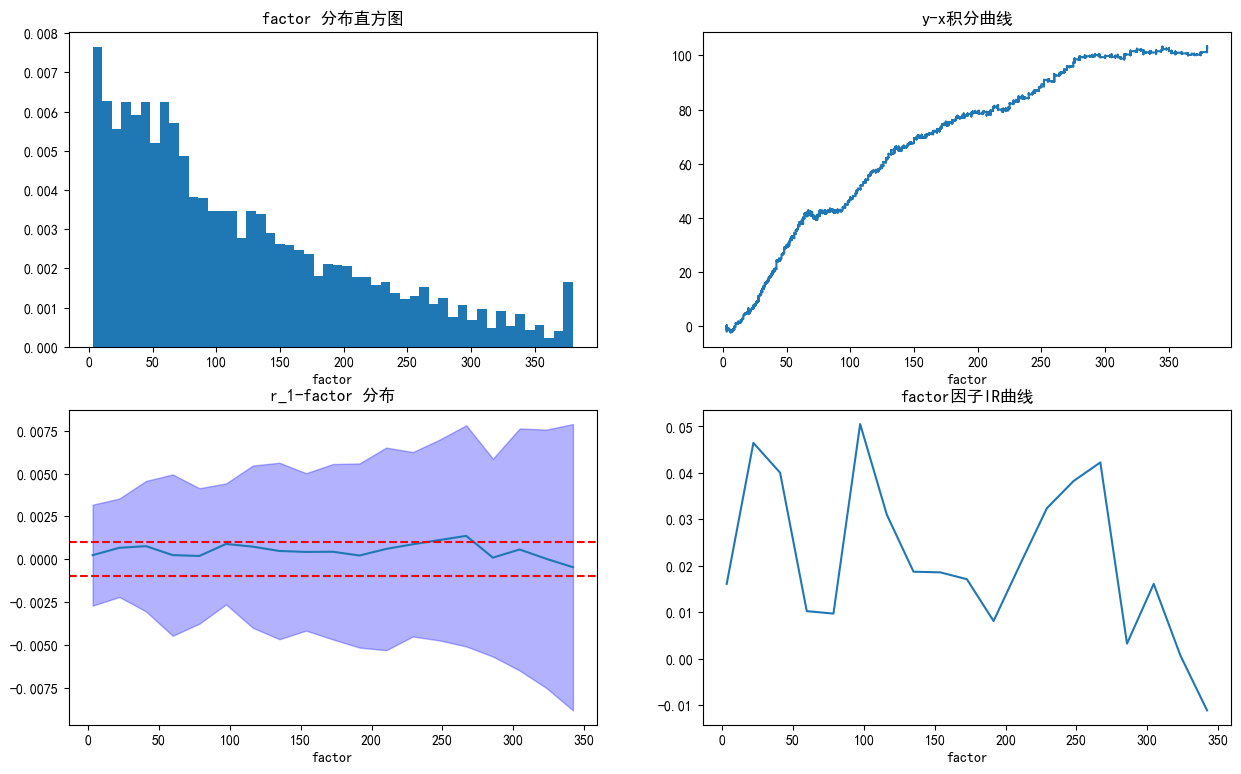

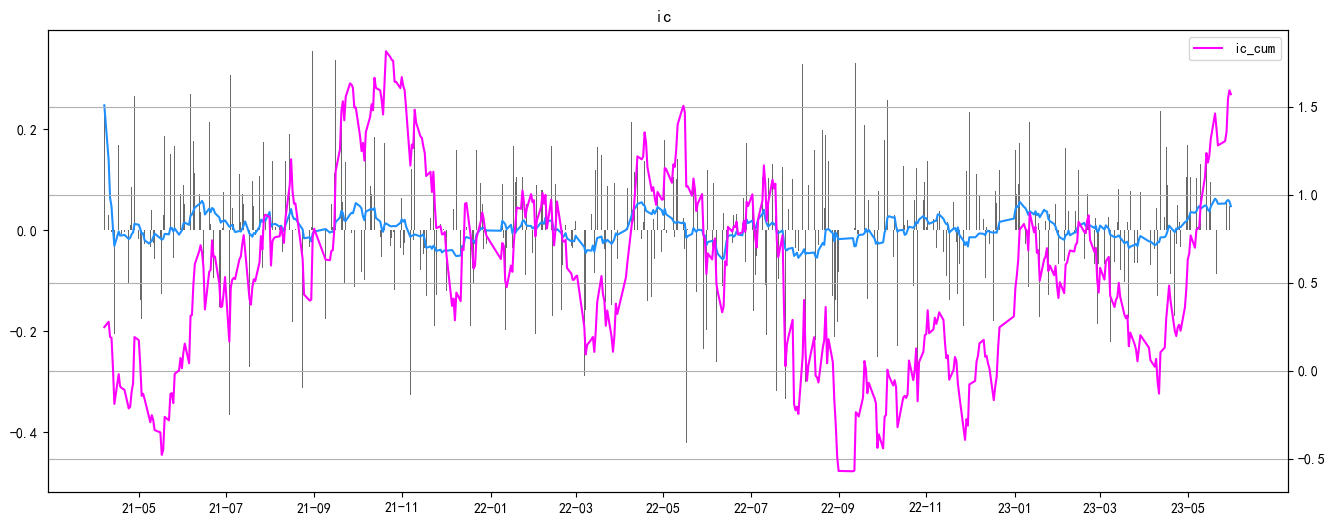

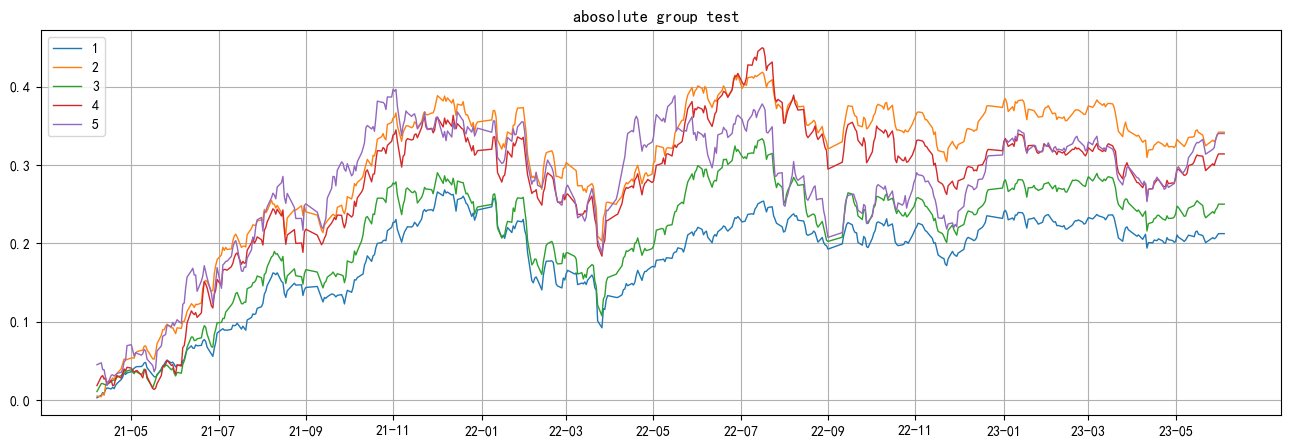

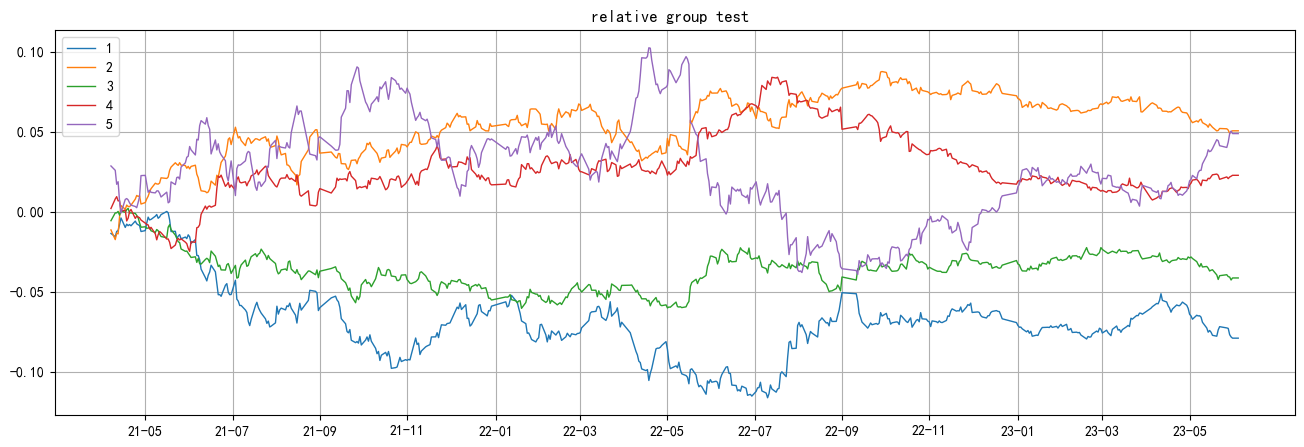

In [24]:
look(df_rank,'factor','r_1',thresh=0.01, div_num=20)
analyse_ic(df_rank,'factor','r_1')    
analyse_group_new(df_rank,'factor','r_1',is_alpha=False,num_group=5)
analyse_group_new(df_rank,'factor','r_1',is_alpha=True,num_group=5)

### BS Model

<Figure size 1500x1200 with 0 Axes>

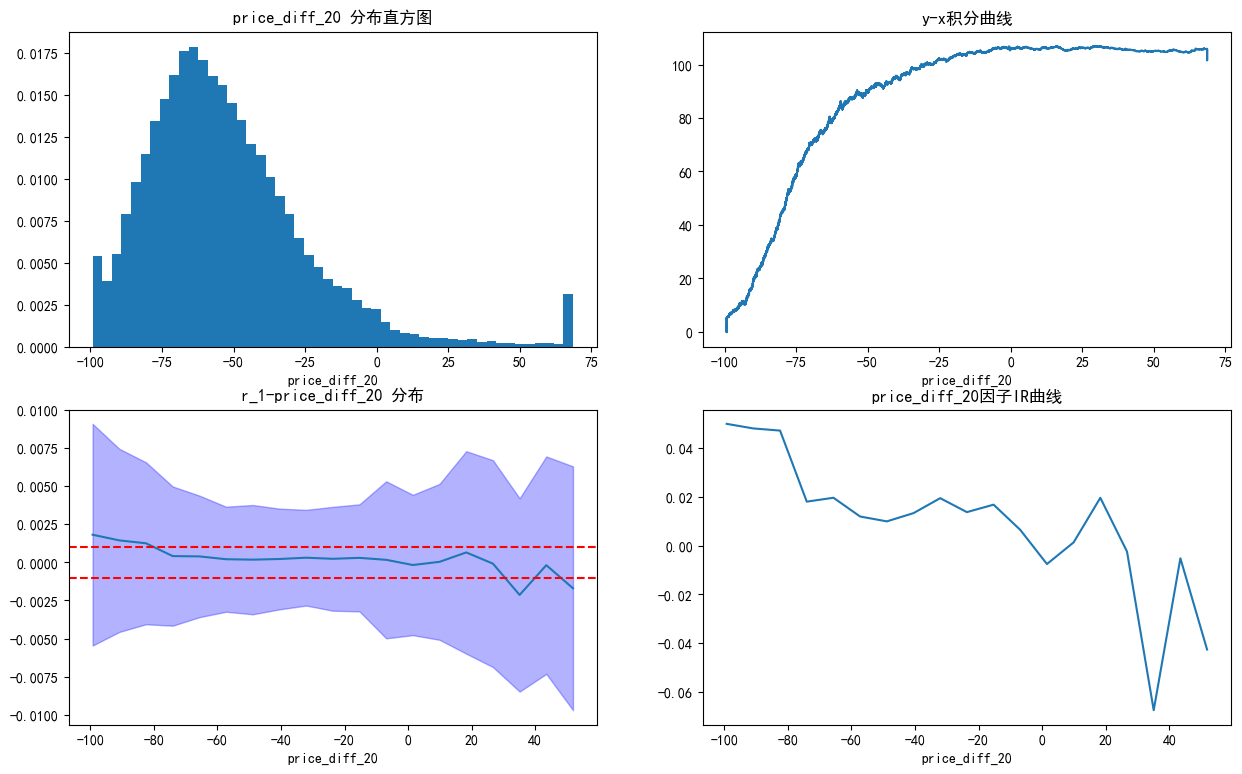

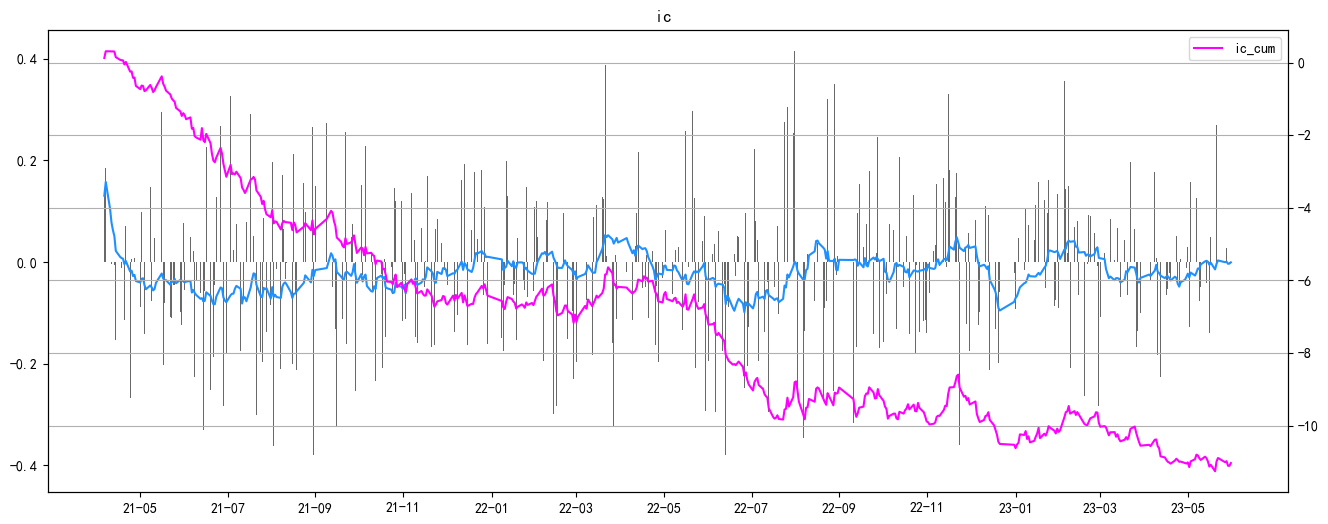

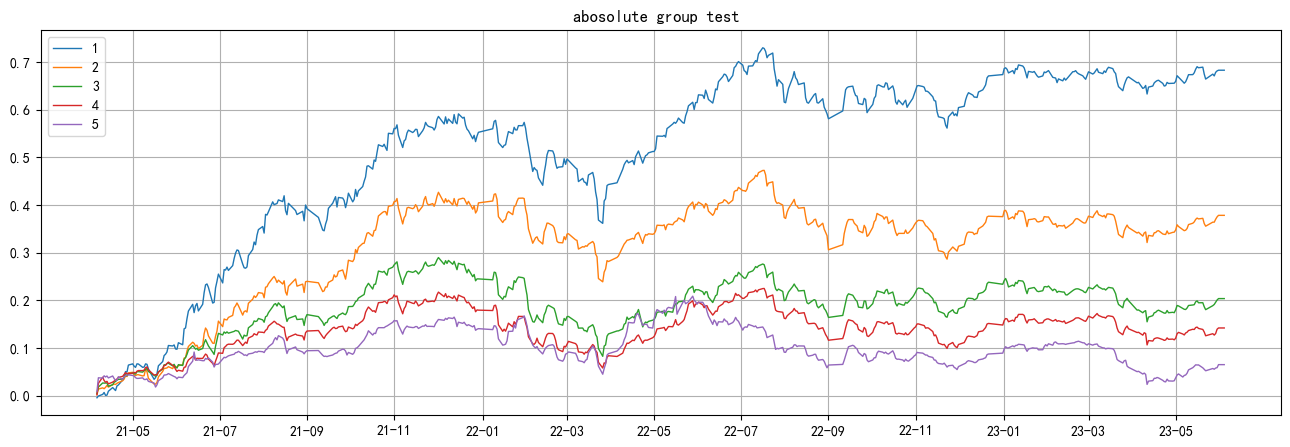

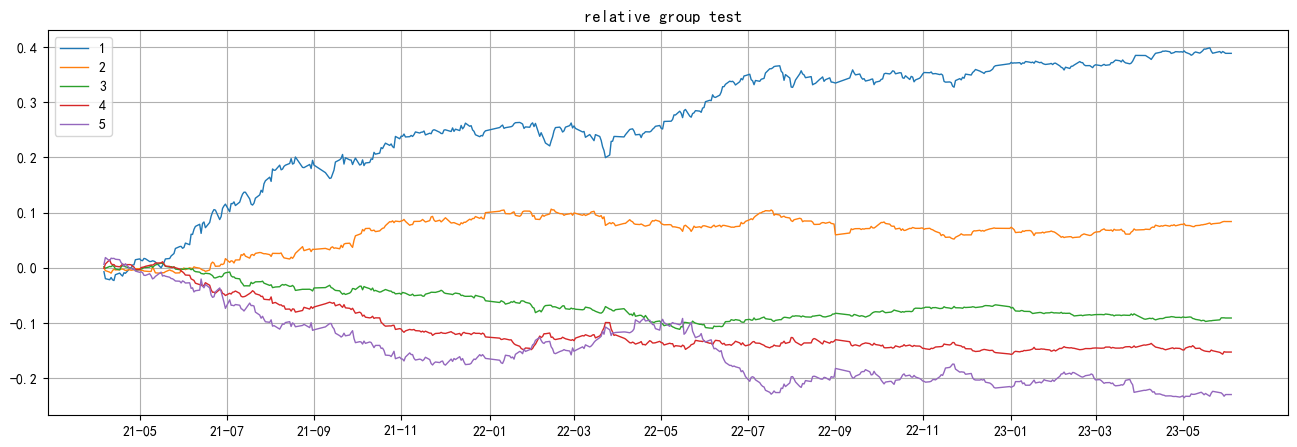

In [25]:
look(data,factor1,'r_1',thresh=0.01, div_num=20)
analyse_ic(data,factor1,'r_1')    
analyse_group_new(data,factor1,'r_1',is_alpha=False,num_group=5)
analyse_group_new(data,factor1,'r_1',is_alpha=True,num_group=5)